# Introduction to Recommender Systems

<p align="center">
    <img width="721" alt="cover-image" src="https://user-images.githubusercontent.com/49638680/204351915-373011d3-75ac-4e21-a6df-99cd1c552f2c.png">
</p>

---

# K-Means based Recommendations

$k$-Means is an unsupervised learning algorithm used for clustering. We are using $k$-Means to build a recommender system based on user-ratings of movies, such that one can categorise users in "appreciation classes" based on the features of movies they liked.

The outline of this lecture is the following:

1. Review of k-means clustering algorithm.
2. Building of user-movie vectors.
3. K-means clustering of vectors.
4. Providing movie recommendations to new users.

## Import necessary libraries

Let's start by importing the libraries we will use in the lecture.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import copy
from typing import Dict, List, TypeVar, Union
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix

from utils.data_utils import load_data
from utils.non_pers_rec import get_genre

import matplotlib.pyplot as plt

Self = TypeVar("Self")

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## K-means clustering

The aim of this section is to briefly review the $k$-means clustering algorithm.

The $k$-means algorithm searches for a pre-determined number of clusters (usually denoted as $k$) within an unlabelled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

* The "cluster center" also called __centroid__ is the arithmetic mean of all the points belonging to the cluster.
* Each point is _closer_ to its own __centroid__ than to other cluster centers.

Those two assumptions are the basis of the $k$-means model.

As you can see, one of the key concepts is the distance one. Indeed, as for $k$-nn, the algorithm is strictly related to the distance choice.

### Build your own $k$-means

There is plenty of nice and efficient implementations of $k$-means. However, in order to better understand the working mechanism, we are now going to implement the simplest version of $k$-means in $2$ dimensions and three clusters making use of the only numpy library. 
We want to be sure the centroids are randomly initialised.

_Note_: You only need `pandas`, `numpy` and `copy` for this. Eventually, `matplotlib` to plot results.

To help you, a brief recall. $k$-means clustering is a clustering algorithm that aims to partition $n$ observations into $k$ clusters.

There are 3 steps:

* __Initialisation__ – $k$ initial “means” (centroids) are generated at random;
* __Assignment__ – $k$ clusters are created by associating each observation with the nearest centroid;
* __Update__ – The centroid of the clusters becomes the new mean.

_Assignment_ and _Update_ are repeated iteratively until _convergence_.

* __Convergence__ – when no point is re-assigned to a different cluster after a step.

The end result is that the sum of squared errors is minimised between points and their respective centroids.

<p align="center">
    <img width="1200" src="https://miro.medium.com/max/1400/1*b2sO2f--yfZiJazc5rYSpg.gif">
</p>

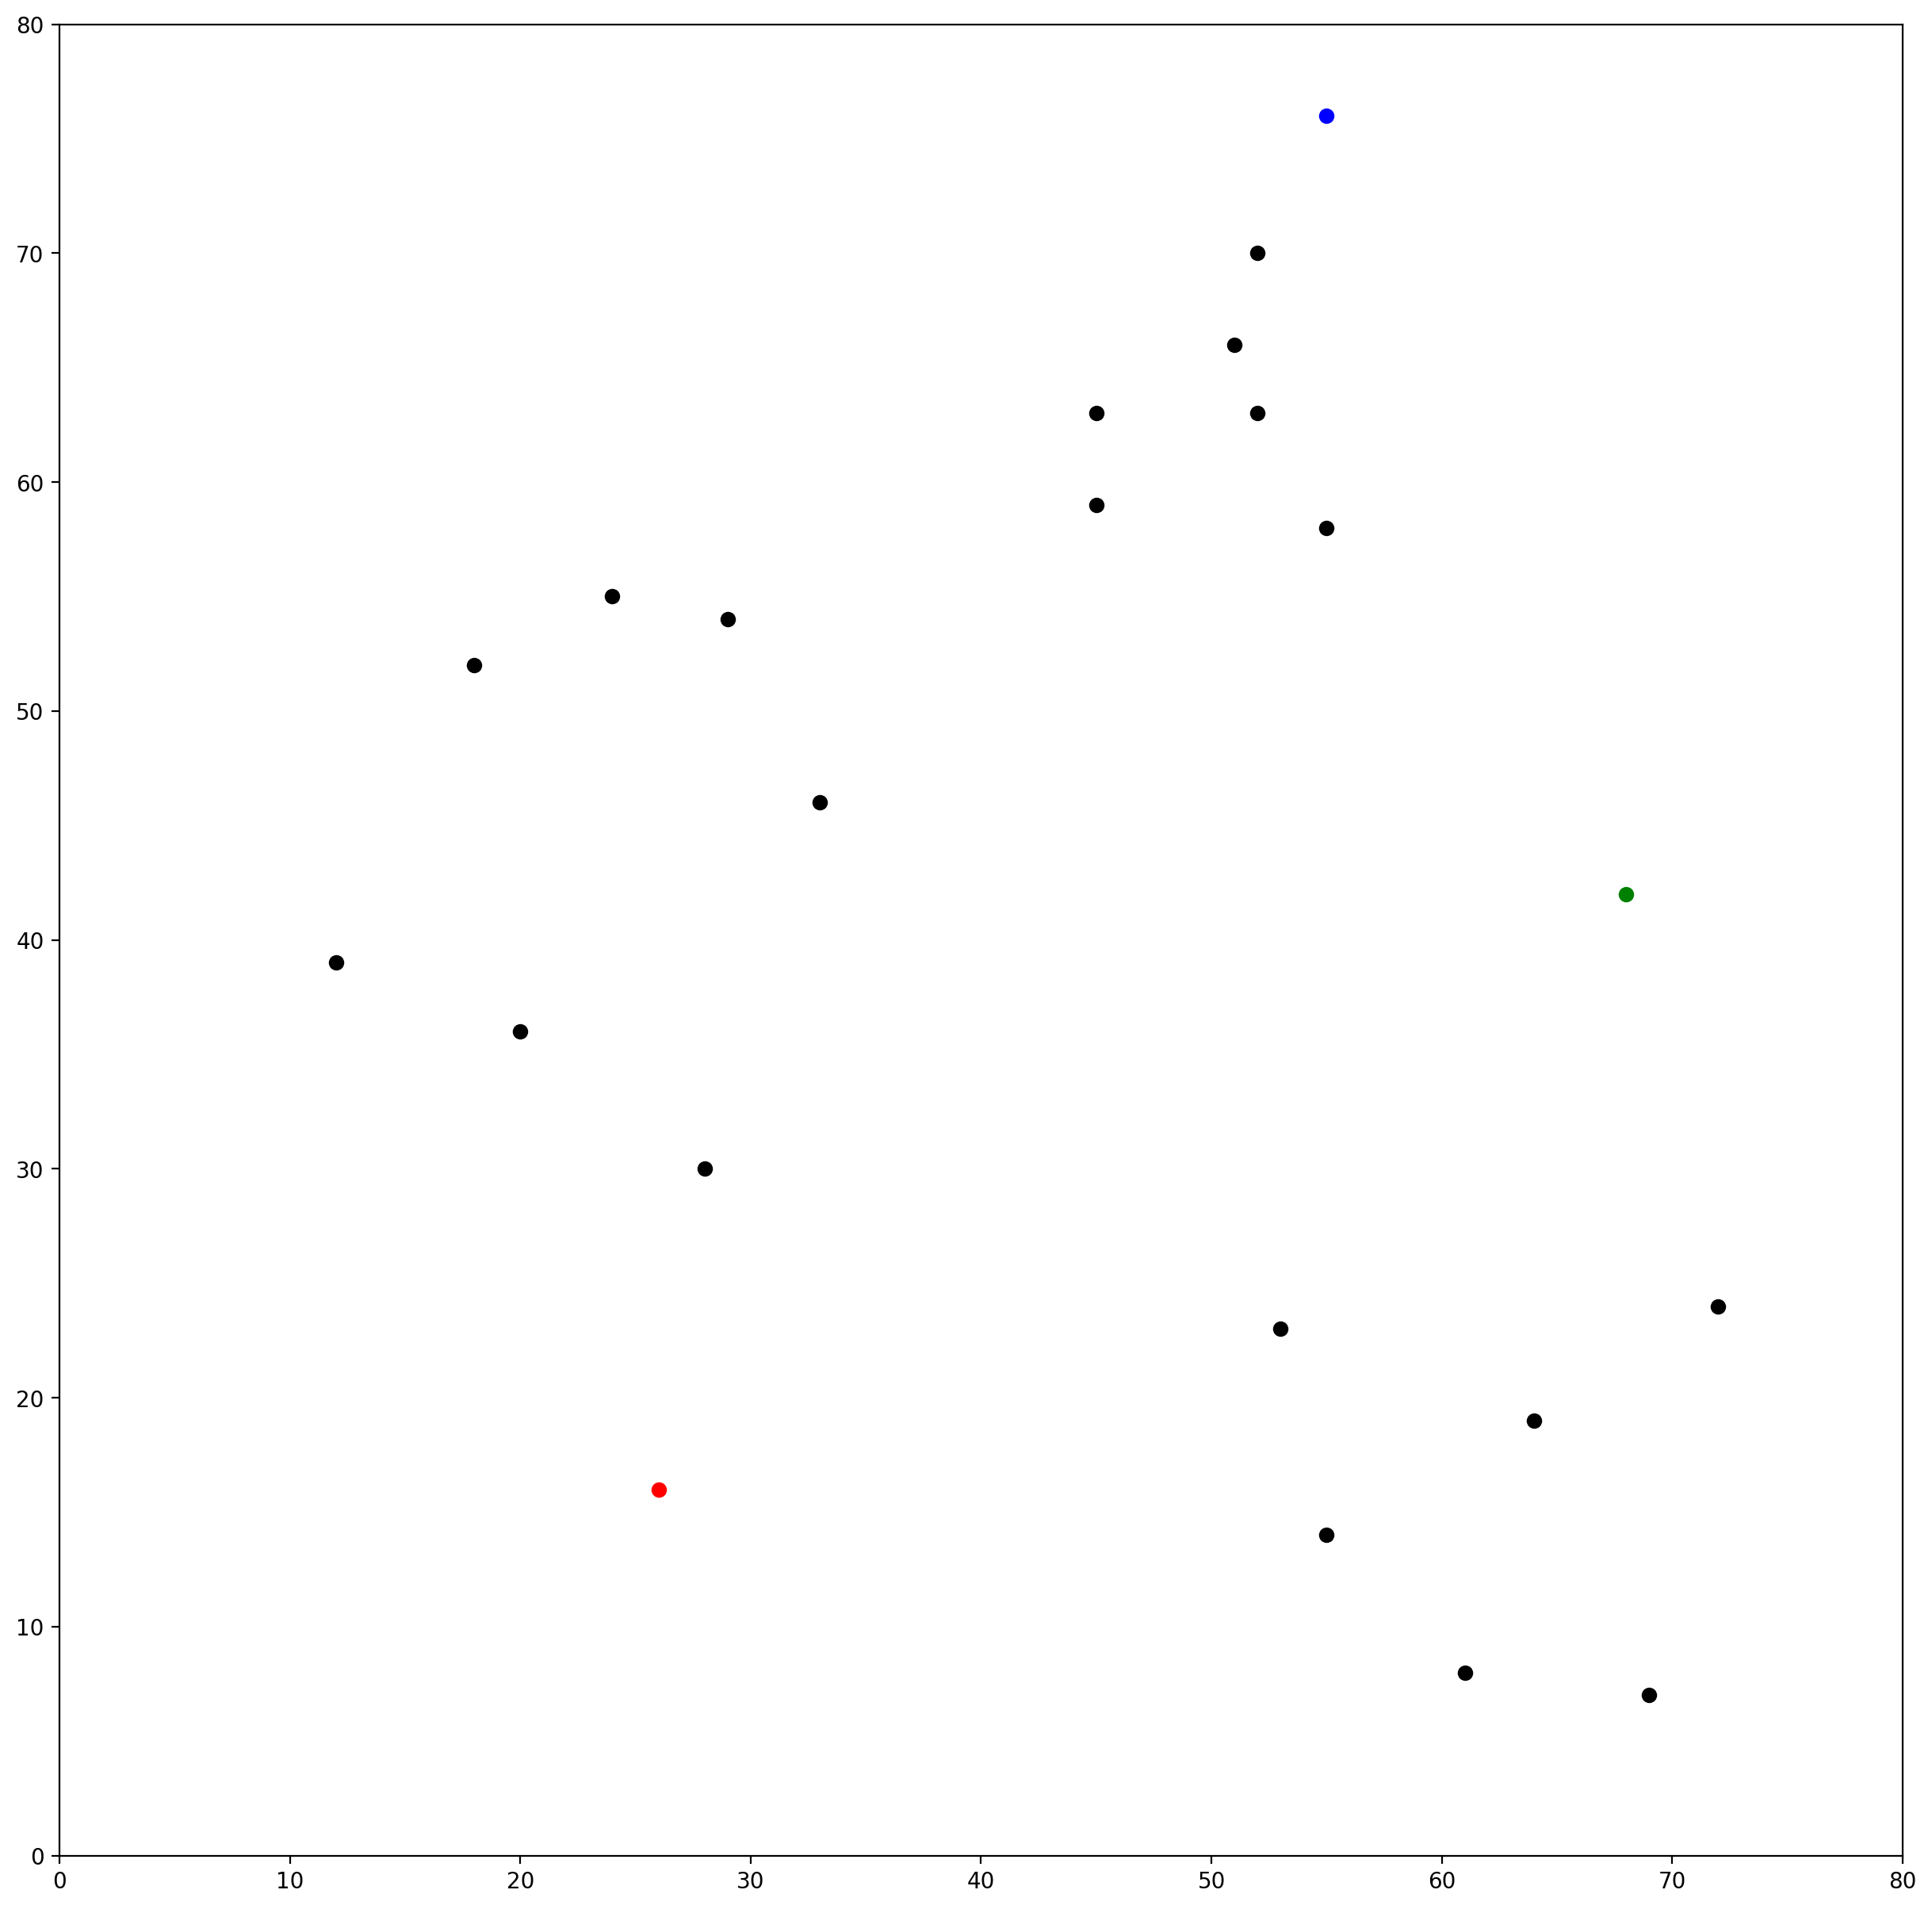

In [2]:
## Initialisation stage

df = pd.DataFrame(
    {
        "x": [
            12,
            20,
            28,
            18,
            29,
            33,
            24,
            45,
            45,
            52,
            51,
            52,
            55,
            53,
            55,
            61,
            64,
            69,
            72,
        ],
        "y": [39, 36, 30, 52, 54, 46, 55, 59, 63, 70, 66, 63, 58, 23, 14, 8, 19, 7, 24],
    }
)


np.random.seed(200)
k = 3
# centroids[i] = [x, y]
centroids = {
    i + 1: [np.random.randint(0, 80), np.random.randint(0, 80)] for i in range(k)
}

fig = plt.figure(figsize=(15, 15))
plt.scatter(df["x"], df["y"], color="k")
colmap = {1: "r", 2: "g", 3: "b"}
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.show()

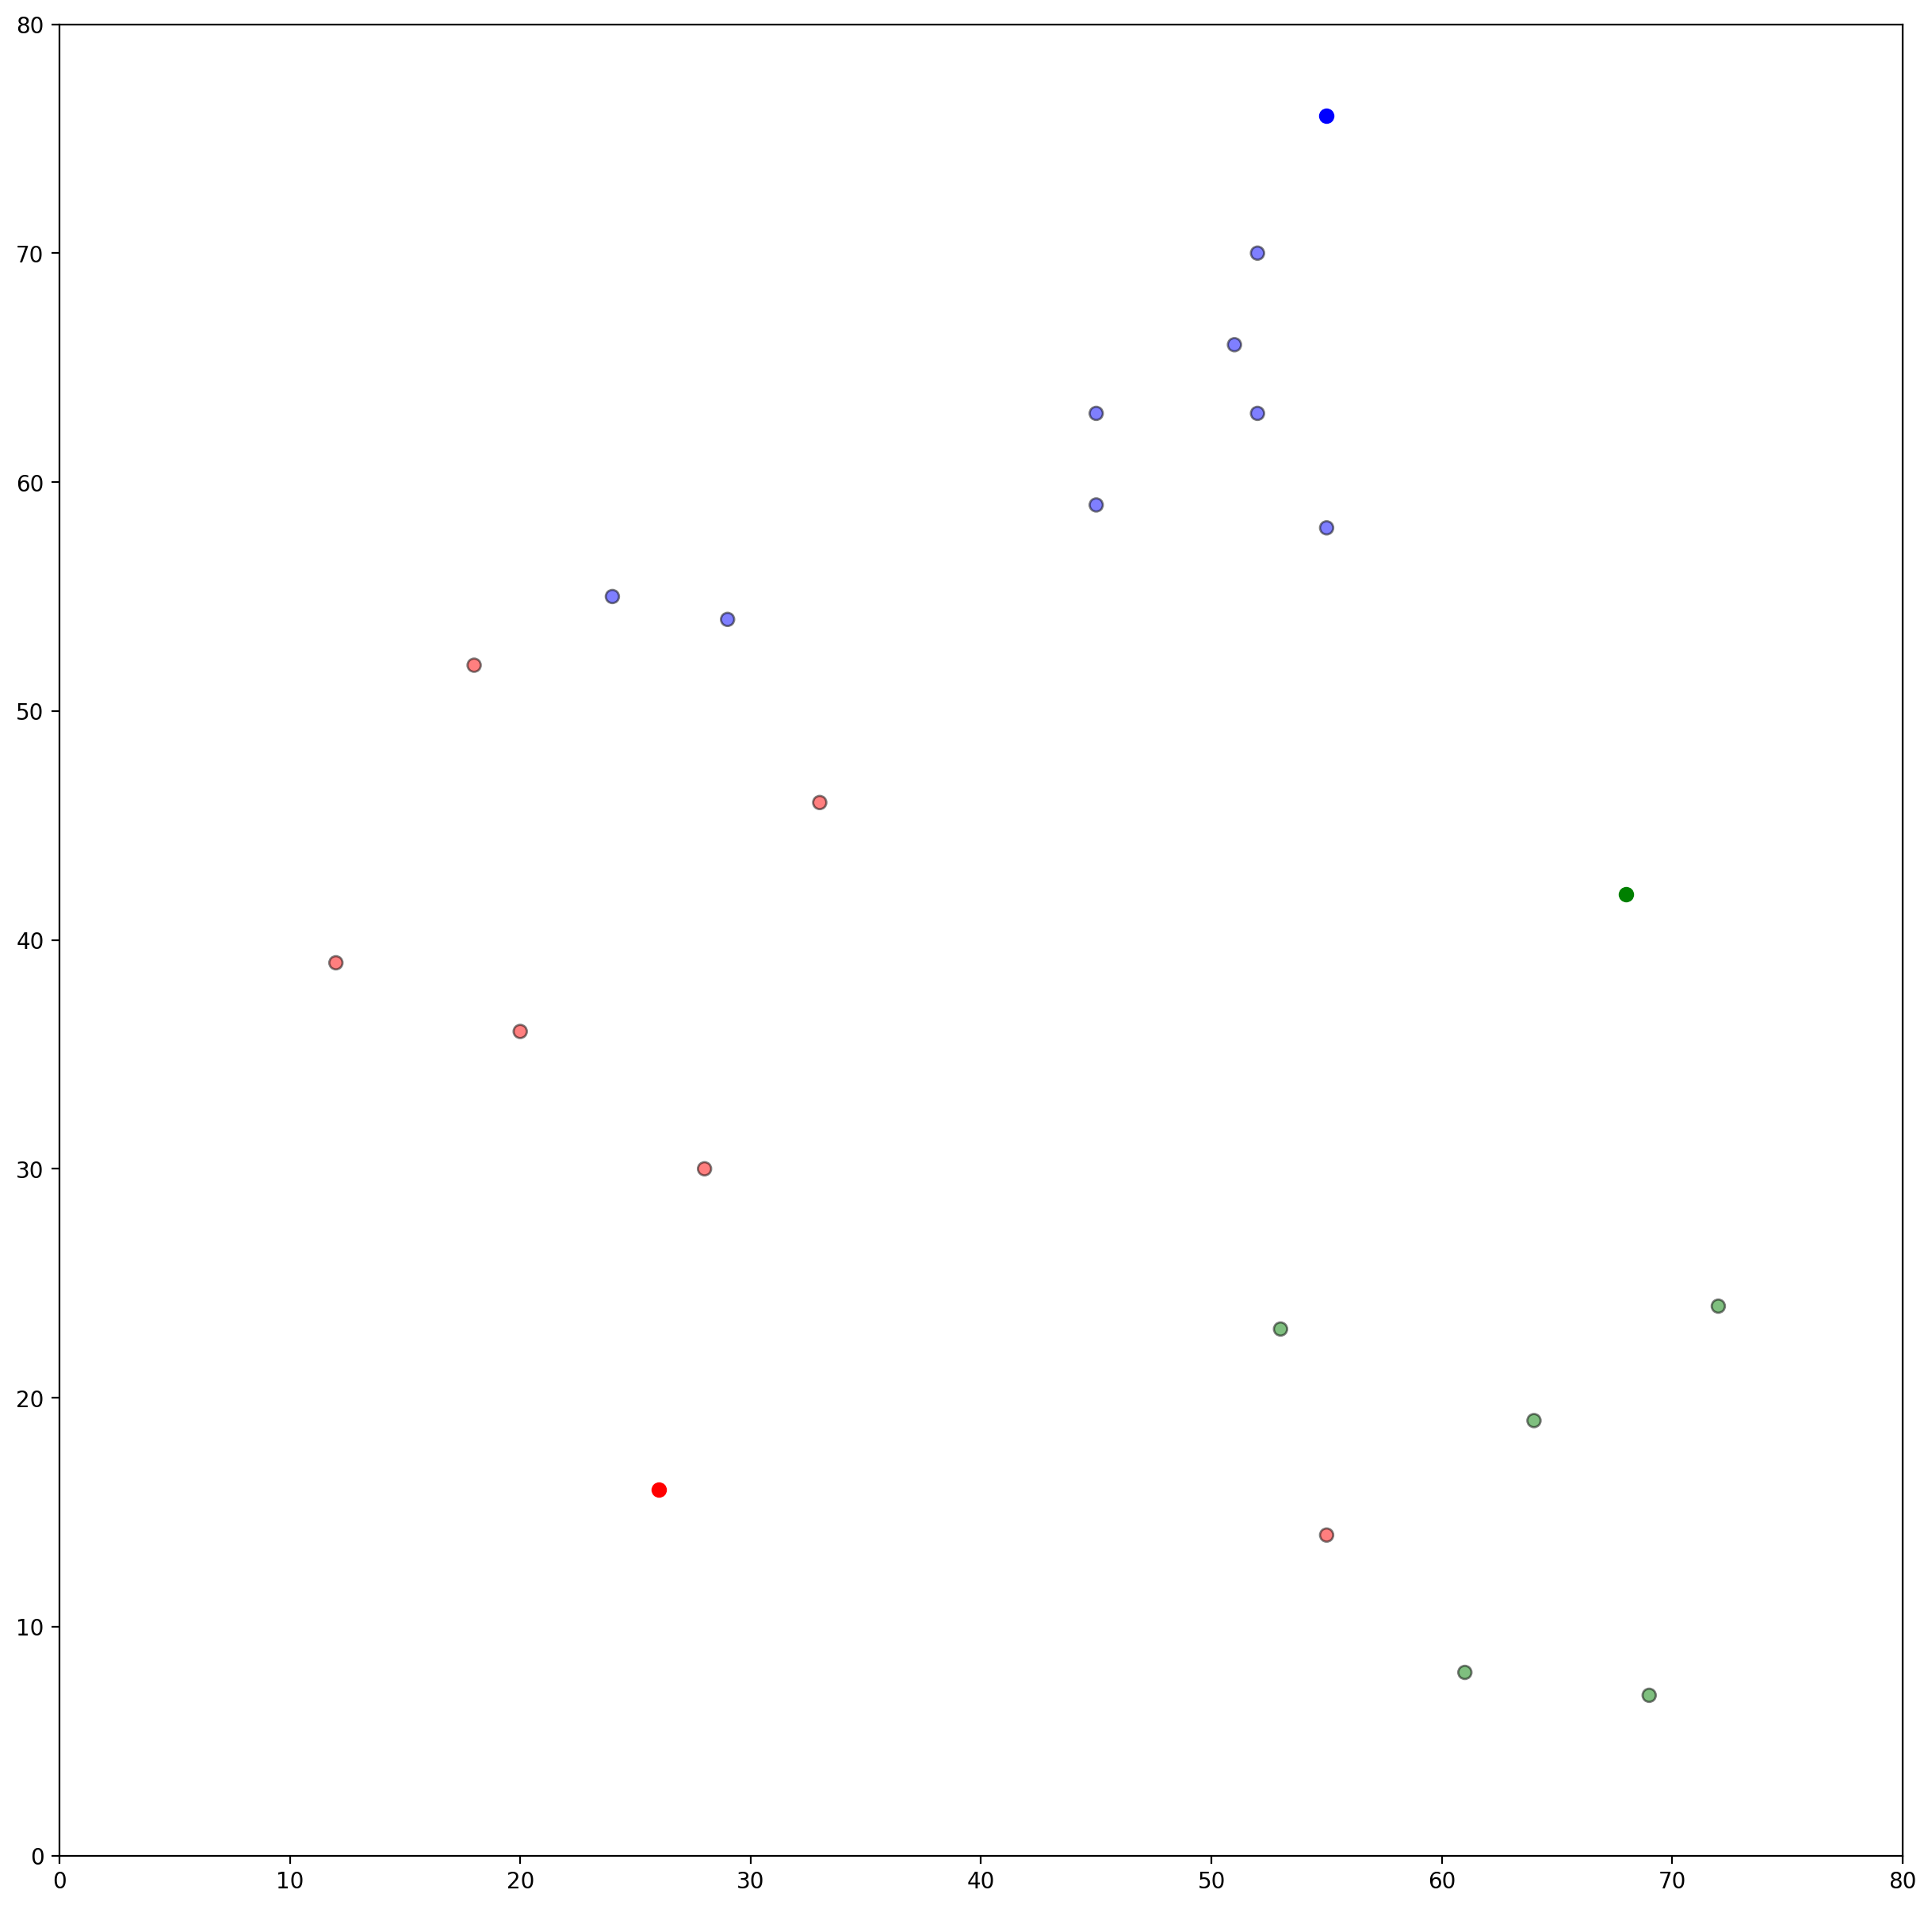

In [3]:
## Assignment Stage


def assignment(df, centroids):
    for i in centroids.keys():
        # sqrt((x1 - x2)^2 - (y1 - y2)^2)
        df["distance_from_{}".format(i)] = np.sqrt(
            (df["x"] - centroids[i][0]) ** 2 + (df["y"] - centroids[i][1]) ** 2
        )
    centroid_distance_cols = ["distance_from_{}".format(i) for i in centroids.keys()]
    df["closest"] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    df["closest"] = df["closest"].map(lambda x: int(x.lstrip("distance_from_")))
    df["color"] = df["closest"].map(lambda x: colmap[x])
    return df


df = assignment(df, centroids)

fig = plt.figure(figsize=(15, 15))
plt.scatter(df["x"], df["y"], color=df["color"], alpha=0.5, edgecolor="k")
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.show()

In [4]:
df.head()

,x,y,distance_from_1,distance_from_2,distance_from_3,closest,color
0,12,39,26.925824,56.080300,56.727418,1,r
1,20,36,20.880613,48.373546,53.150729,1,r
2,28,30,14.142136,41.761226,53.338541,1,r
3,18,52,36.878178,50.990195,44.102154,1,r
4,29,54,38.118237,40.804412,34.058773,3,b


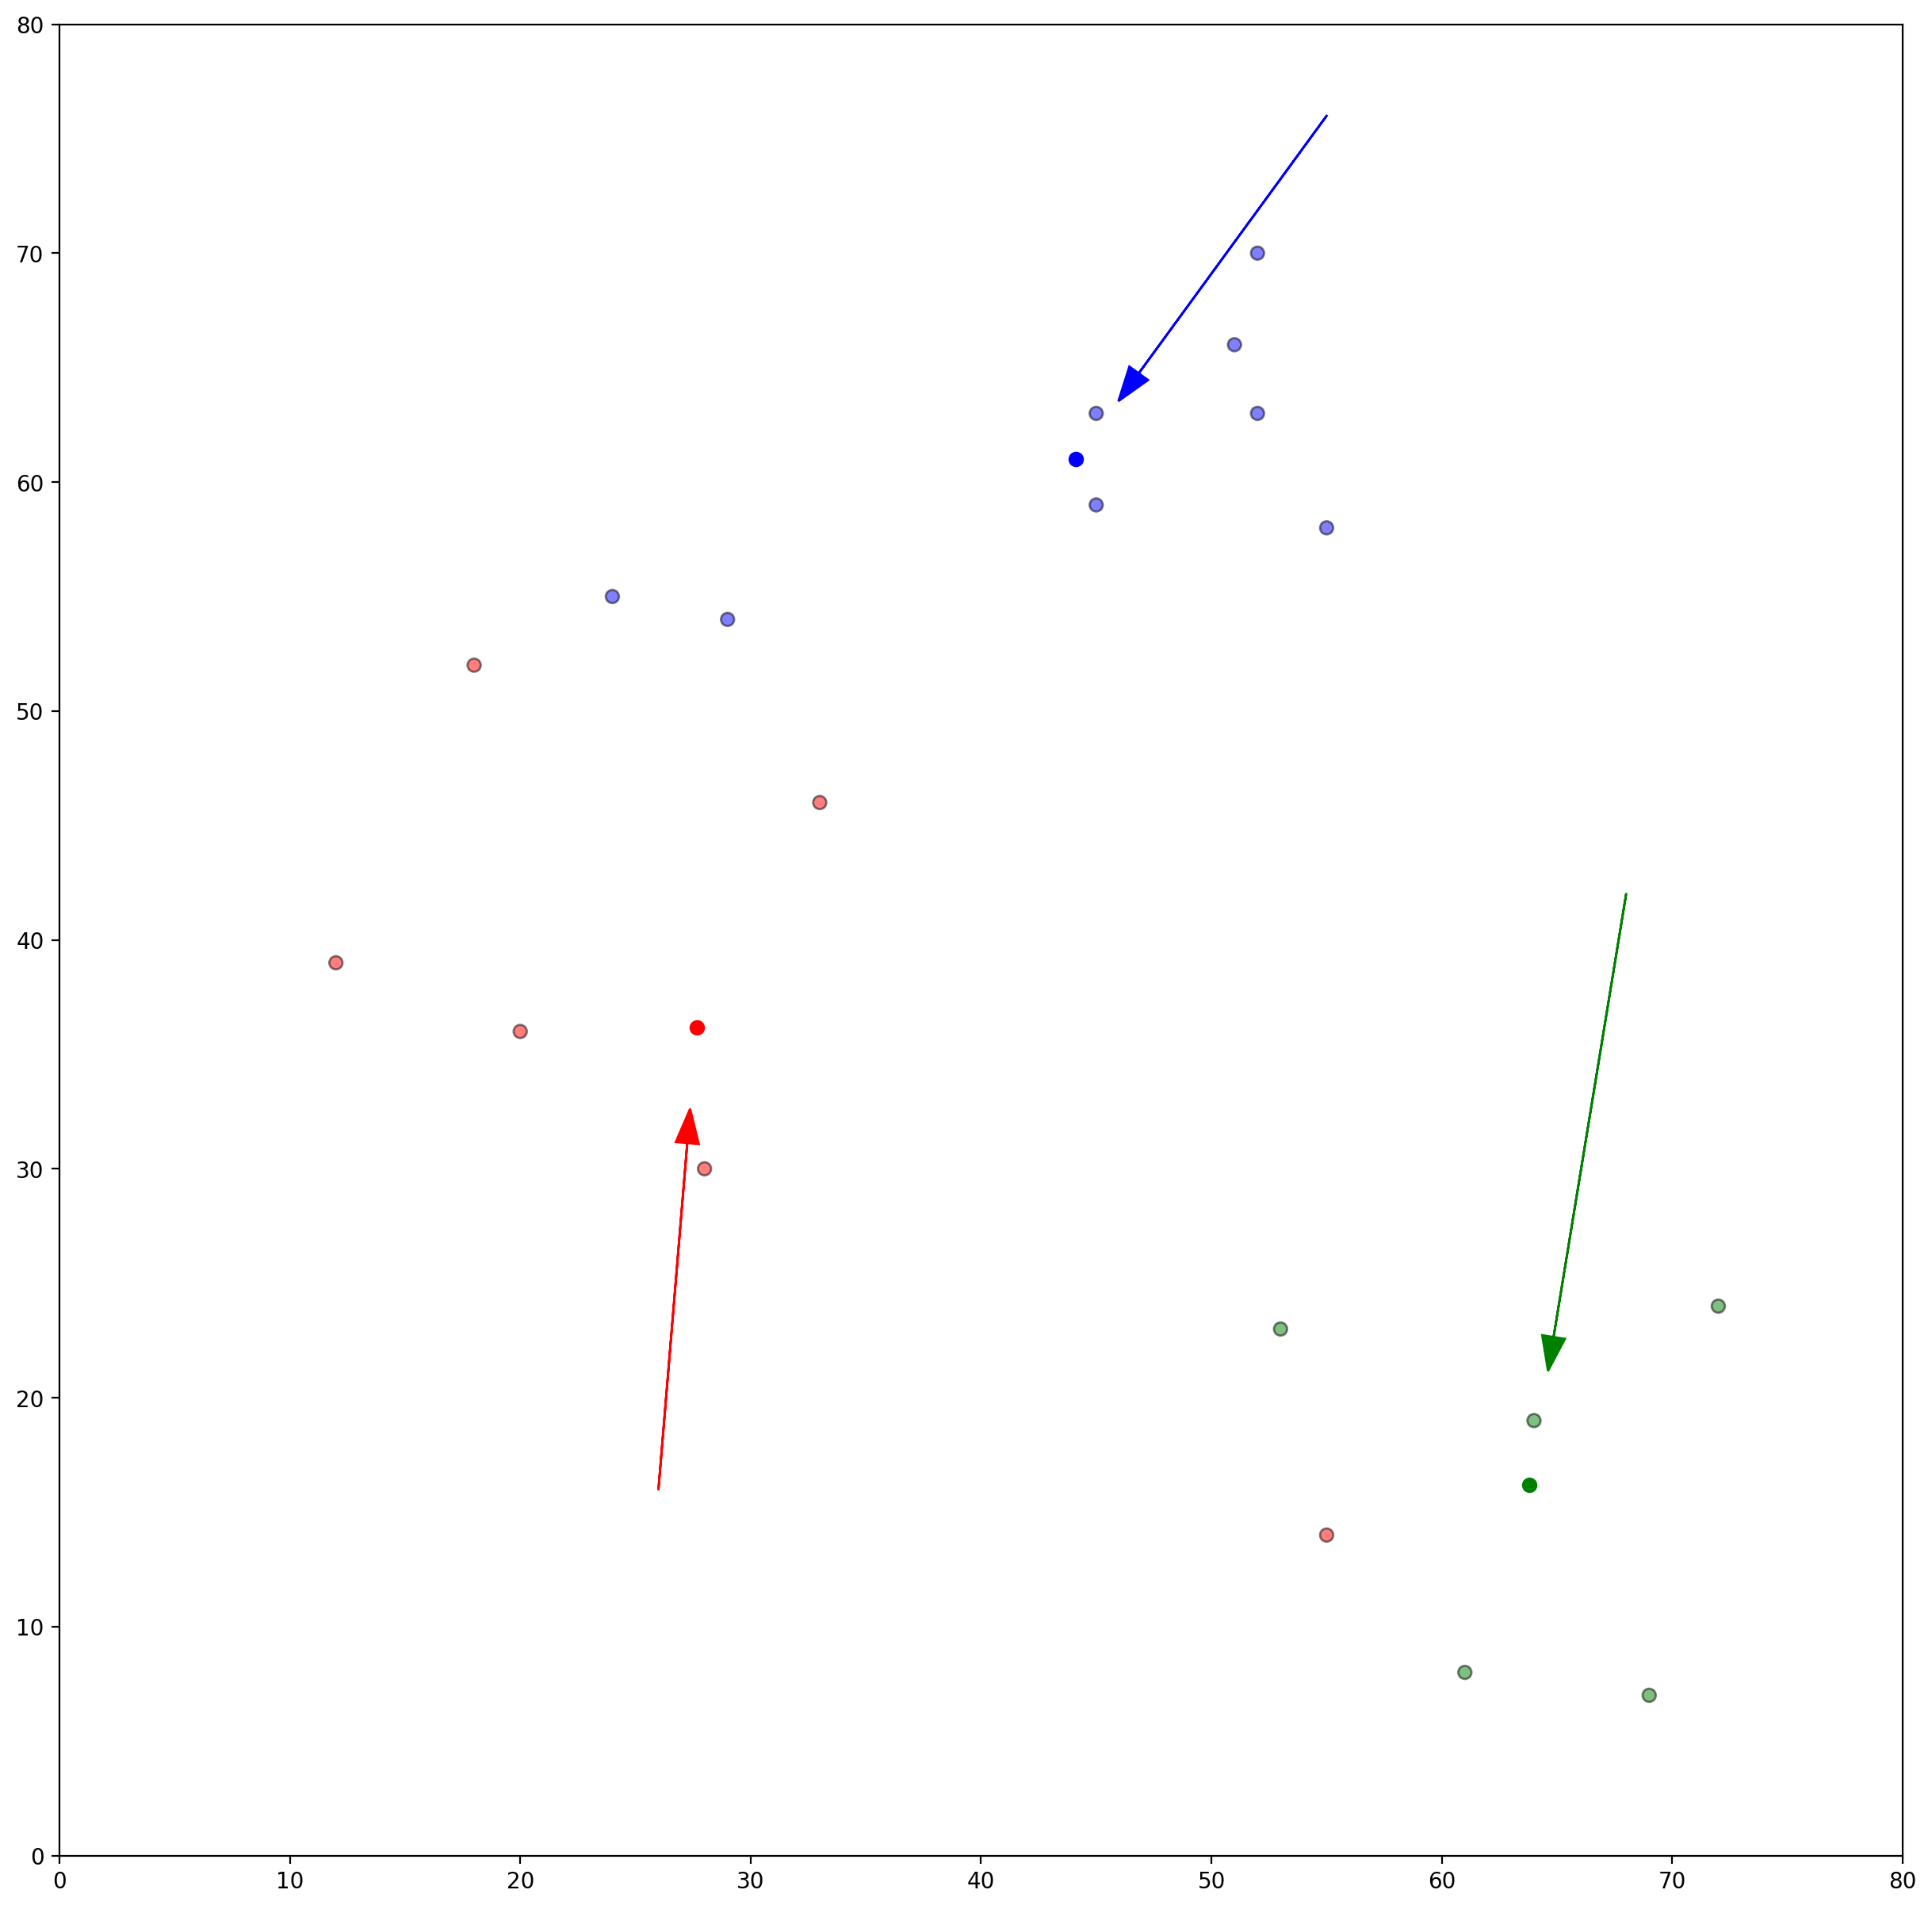

In [5]:
## Update Stage

old_centroids = copy.deepcopy(centroids)


def update(k):
    for i in k.keys():
        k[i][0] = np.mean(df[df["closest"] == i]["x"])
        k[i][1] = np.mean(df[df["closest"] == i]["y"])
    return k


centroids = update(centroids)

fig = plt.figure(figsize=(15, 15))
ax = plt.axes()
plt.scatter(df["x"], df["y"], color=df["color"], alpha=0.5, edgecolor="k")
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 80)
plt.ylim(0, 80)
for i in old_centroids.keys():
    old_x = old_centroids[i][0]
    old_y = old_centroids[i][1]
    dx = (centroids[i][0] - old_centroids[i][0]) * 0.75
    dy = (centroids[i][1] - old_centroids[i][1]) * 0.75
    ax.arrow(
        old_x, old_y, dx, dy, head_width=1, head_length=1.5, fc=colmap[i], ec=colmap[i]
    )  # arrows to show centroids moving
plt.show()

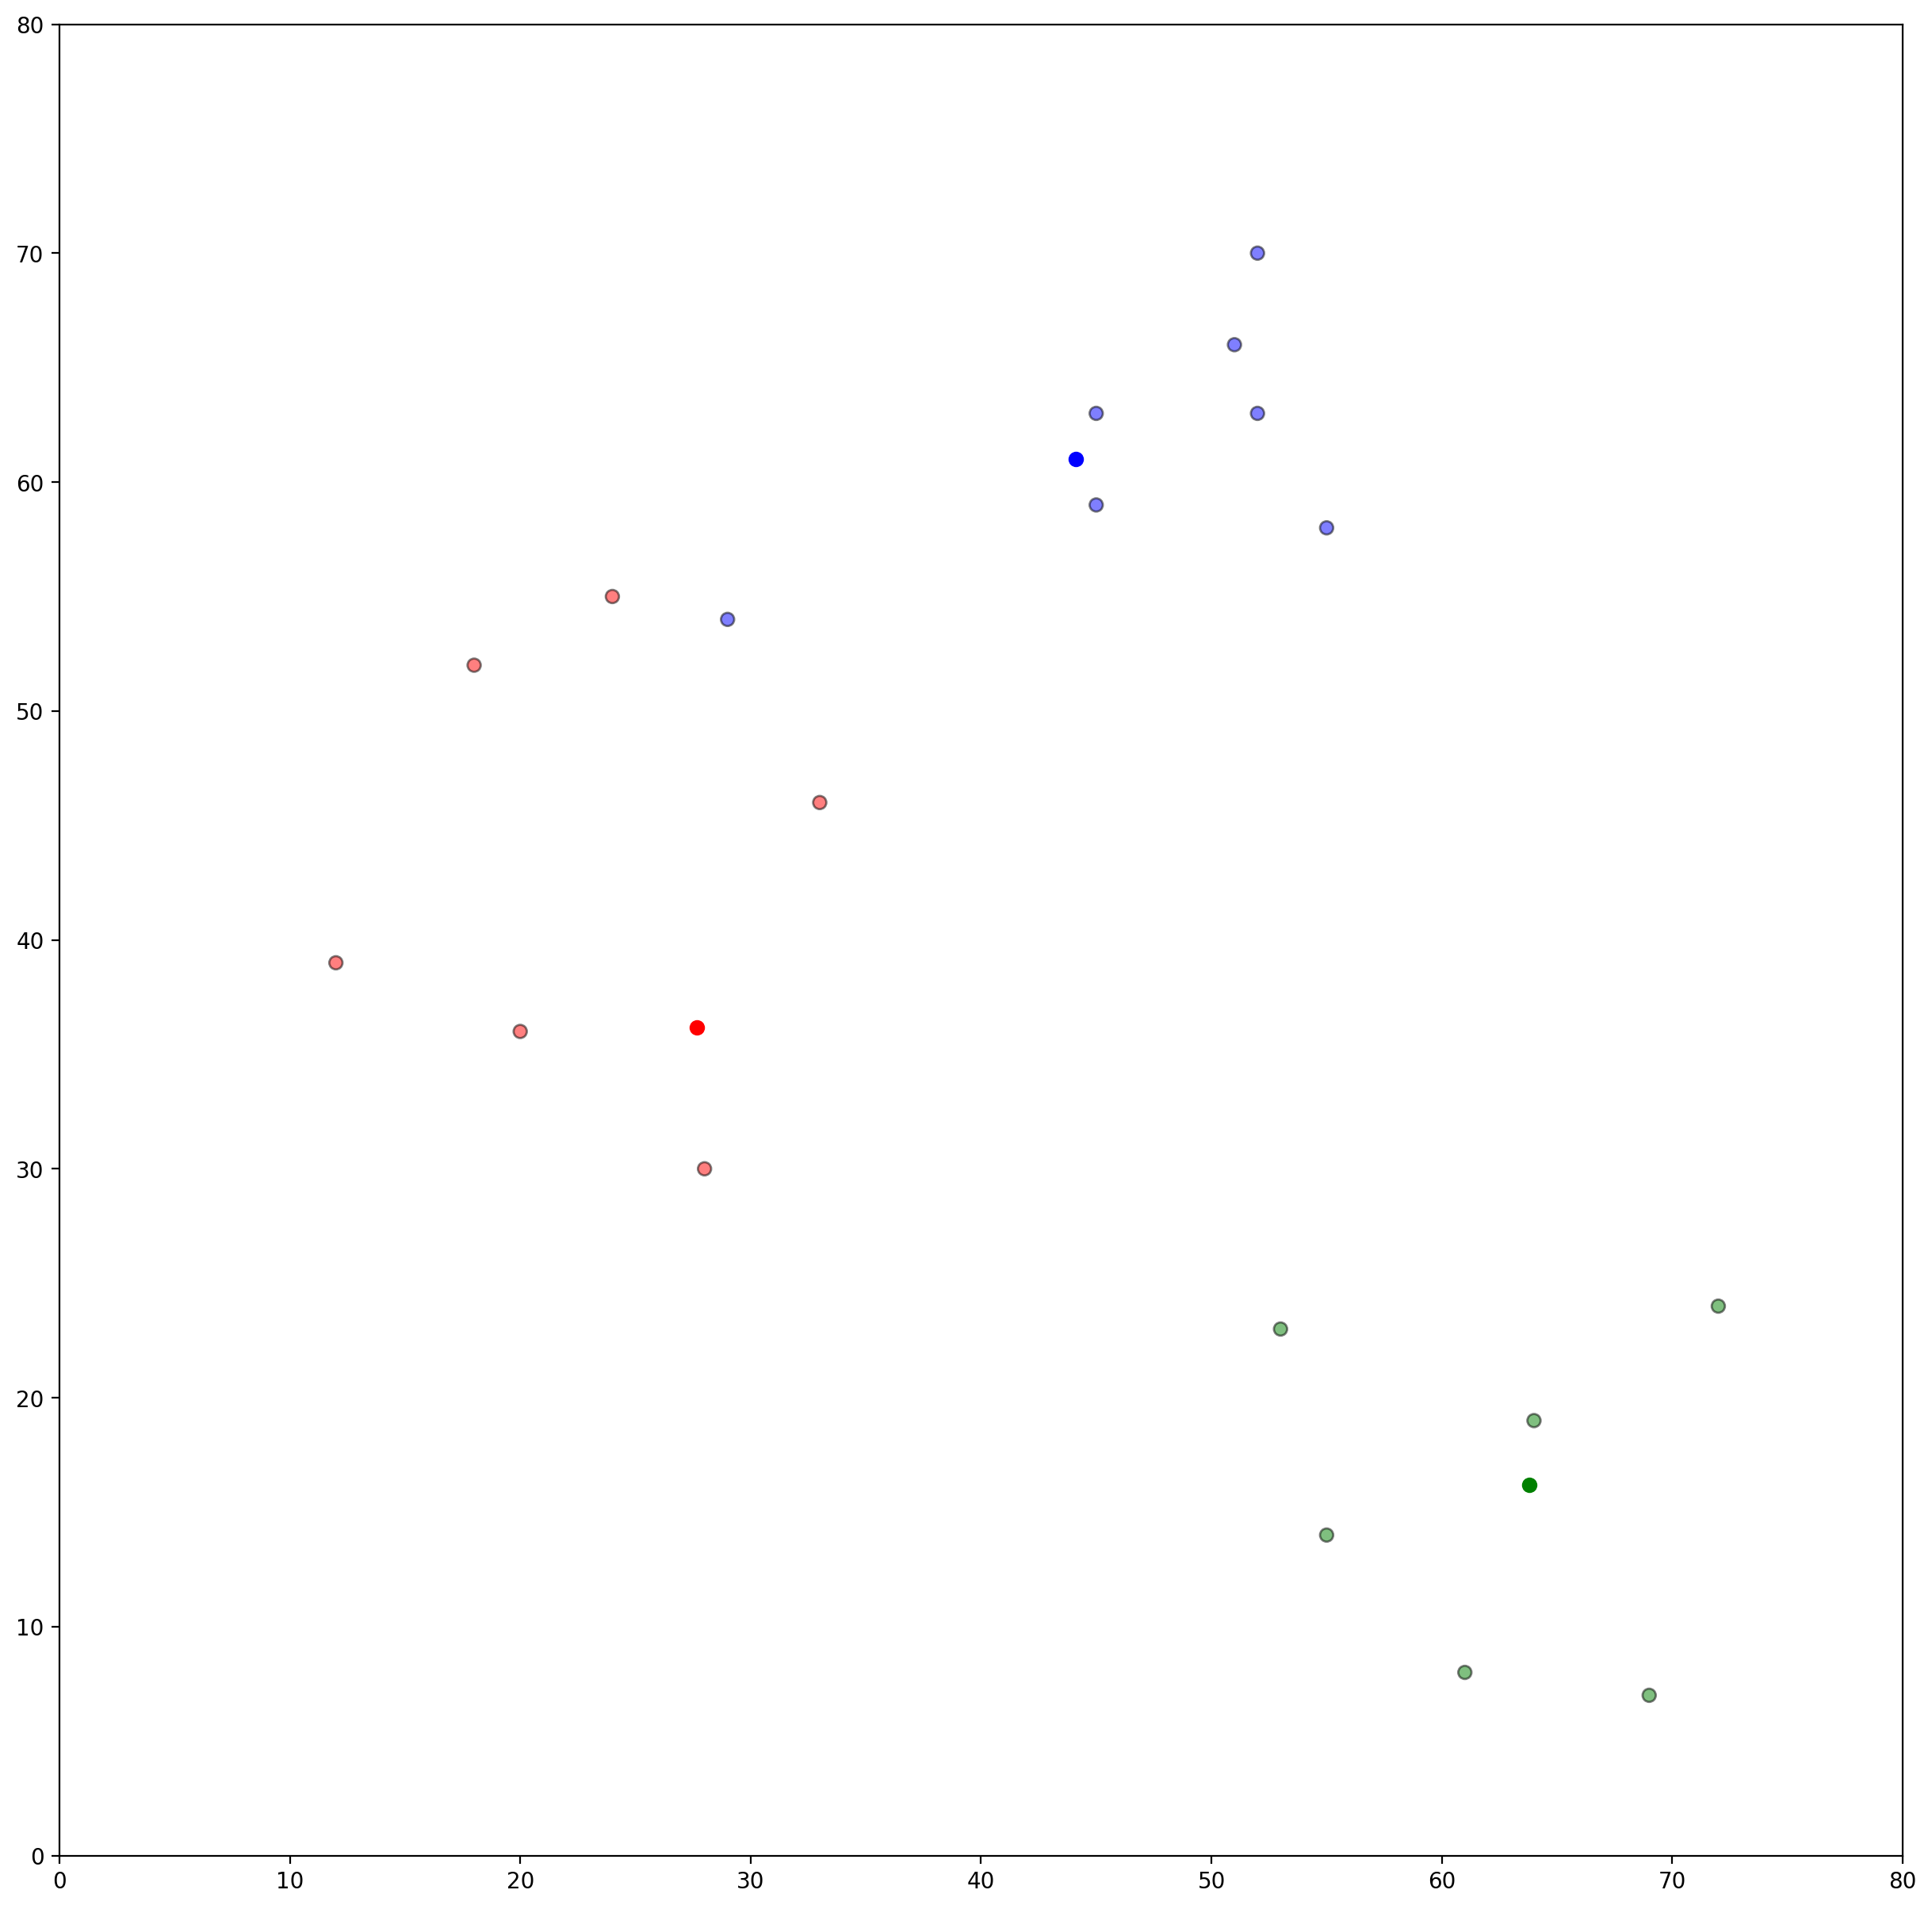

In [6]:
## Repeat Assigment Stage

df = assignment(df, centroids)

# Plot results
fig = plt.figure(figsize=(15, 15))
plt.scatter(df["x"], df["y"], color=df["color"], alpha=0.5, edgecolor="k")
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.show()

Note that one of the reds is now green and one of the blues is now red.

We are getting closer.

We now repeat until the __convergence condition__ is met. 
> There are no changes to any of the clusters.

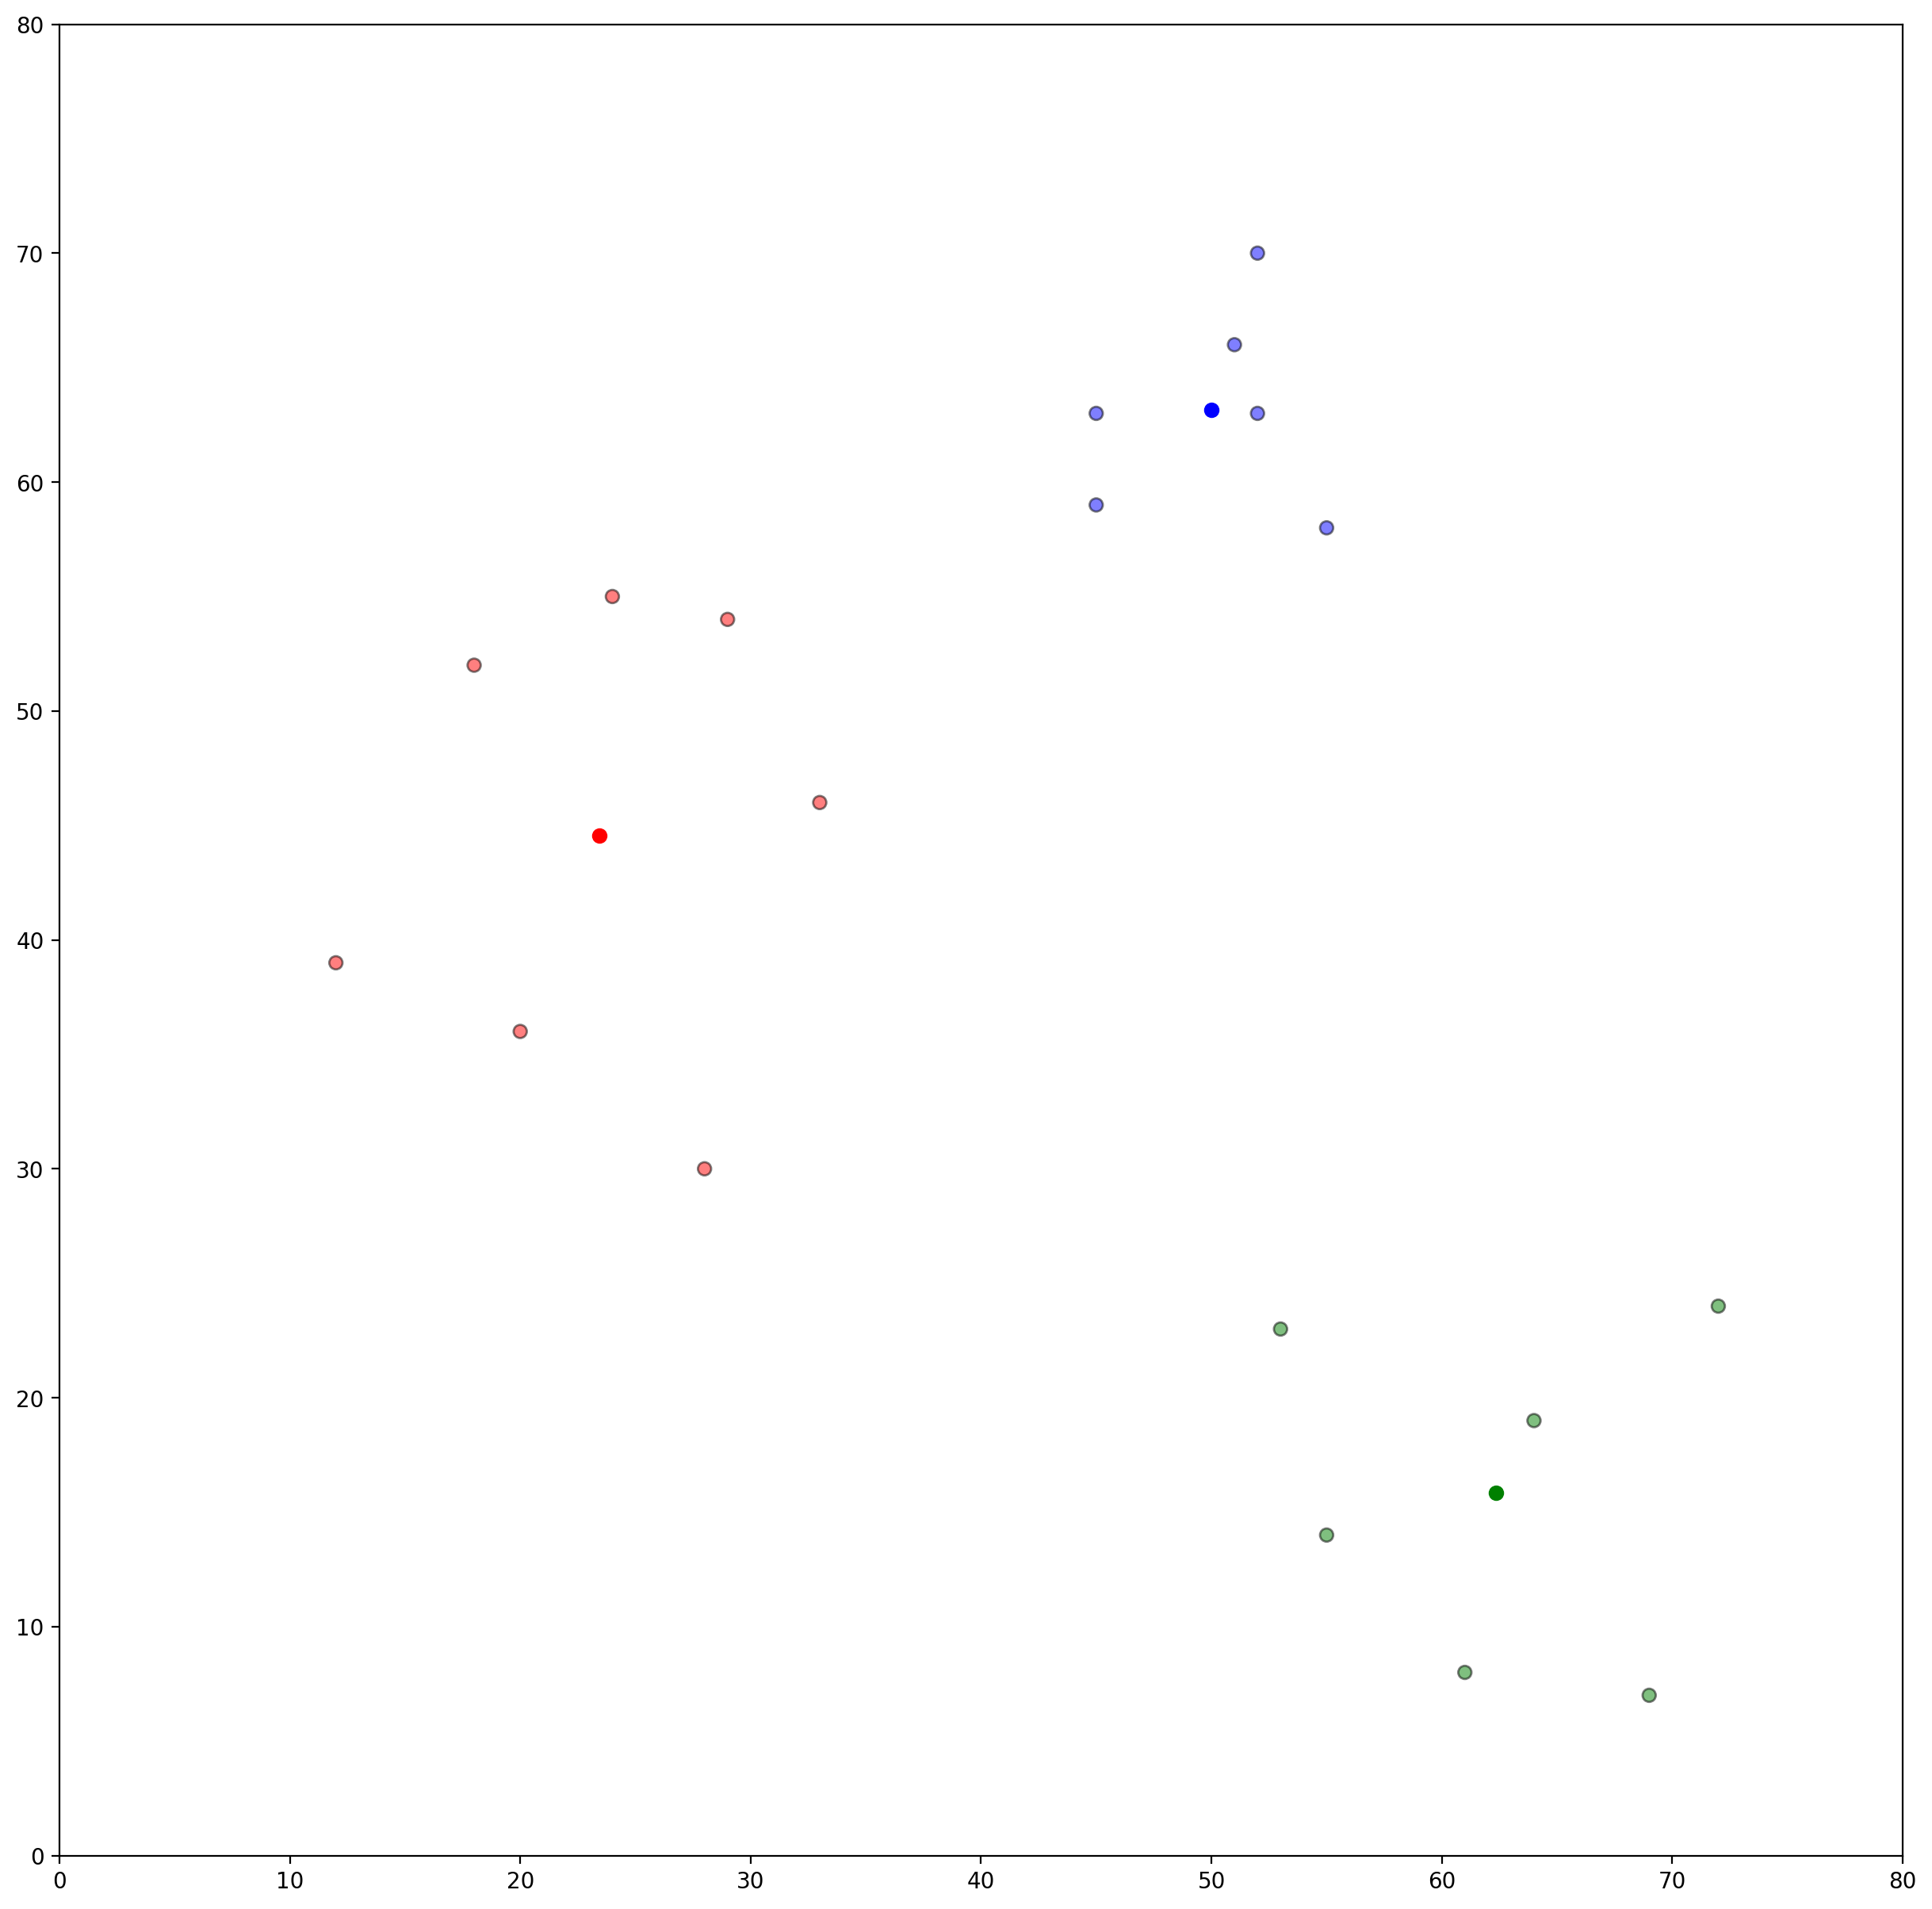

In [7]:
# Continue until all assigned categories do not change anymore
while True:
    closest_centroids = df["closest"].copy(deep=True)
    centroids = update(centroids)
    df = assignment(df, centroids)
    if closest_centroids.equals(df["closest"]):
        break

fig = plt.figure(figsize=(15, 15))
plt.scatter(df["x"], df["y"], color=df["color"], alpha=0.5, edgecolor="k")
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 80)
plt.ylim(0, 80)
plt.show()

So we have $3$ clear clusters with $3$ centroids at the centre of these clusters.

### How do we choose the number of clusters?

This is a very interesting question. 
And the funny fact is that there is not a precise answer.

There are a few heuristic methods to choose the number of clusters, here we present one of them: _elbow method_.

#### Elbow method

As said, the _elbow method_ is a commonly used technique to determine the optimal number of clusters in k-means clustering. 

It involves calculating the _within-cluster sum of squares_  or _inertia_ for several values of $k$.

The inertia is a measure of the variability of data within each cluster in k-means clustering. It is calculated as the sum of the squared Euclidean distances between each data point and the centroid (mean) of its assigned cluster.

To be more specific, for each cluster, the inertia is calculated by:

$$ \mathcal{I} = \sum_{i=1}^k \sum_{x \in \mathcal{C}_i} \left(x - \mu_i\right)^2\, , $$

Here, $k$ is the number of clusters, $\mathcal{C}_i$ is the set of data points in the $i^\mathrm{th}$ cluster, $x$ is a data point in the cluster, $\mu_i$ is the centroid (mean) of the $i^\mathrm{th}$ cluster. 

The inertia is an important metric in $k$-means clustering because it measures how well the data points in a cluster are grouped around their centroid. Ideally, we want to minimize $\mathcal{I}$ by finding the optimal number of clusters such that each cluster is as homogeneous as possible (_i.e._, the data points within each cluster are as similar to each other as possible) and the clusters are as distinct from each other as possible.

Plotting the values of $\mathcal{I}$ calculated for different $k$, against the number of clusters used in the analysis and identifying the "elbow point" where the rate of decrease in $\mathcal{I}$ starts to level off.

Here is how to use the elbow method:

1. First, you perform k-means clustering on your dataset with varying numbers of clusters, say from 1 to 10. For each clustering, you record the WCSS.

2. Next, you plot $\mathcal{I}$ against the number of clusters.

3. The resulting plot will typically show a decreasing trend as the number of clusters increases. However, the rate of decrease will start to level off as the number of clusters increases further. This is because as the number of clusters increases, the clusters become more and more similar, and the reduction in $\mathcal{I}$ becomes less significant.

4. The "_elbow point_" is the point on the plot where the rate of decrease in $\mathcal{I}$ starts to level off. This is where the curve starts to resemble an elbow. This point indicates the optimal number of clusters for your data.

Once you have identified the elbow point, you can use the corresponding number of clusters for your k-means clustering analysis.

<p align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1014/format:webp/1*o-MReWBk68Ob4YvL5lSrDw.png" width="750">
</p>

Indeed $\mathcal{I}$ will tells us how far are centroid from its data points. As we increase number of clusters, WCSS will become small and after some value of K the WCSS will reduce slowly and we will stop there and choose optimal number of clusters. I’ll suggest to Google for elbow method and take a look at more clear examples of elbow method. Here we have figure for intuition of elbow method.

## Methodology for $k$-means providing recommendations

We are going to build a clustering based algorithm to categorise users into groups of same interest by using $k$-means algorithm. 

We will use data, where users has rated movies with $4+$ rating on the supposition of that, if a user is rating a movie $4+$ then he/she may like it. 

In some sense, we are going to use an _implicit feedback_ meaning that we only care if a user _liked_ a movie or not, without worrying about the extent of the feedback.

### Schematics for the $k$-means approach

K-means clustering can be used as a simple approach for building a recommender system. 

Here is how one can use $k$-means to build a recommender system.

1. First, we use a dataset of user-item interactions, the `df_ratings` defined above. Each row in the dataset corresponds to a user, and each column corresponds to an item. The values in the dataset represent the level of interaction between the user and the item (e.g., ratings, clicks, purchases, etc.).

2. Next, we will use $k$-means clustering to cluster users into different groups based on their item interactions. In this case, each user is represented as a vector of item interactions, and the $k$-means algorithm partitions the users into $k$ clusters based on the similarity of their interaction patterns.

3. Once you have the user clusters, you can recommend items to users based on the item interactions of other users in the same cluster. For a given user, you can recommend items that are highly rated or frequently used by other users in the same cluster.

4. To evaluate the performance of the recommender system, you can use a holdout set of user-item interactions to compute metrics such as precision, recall, and $F_1$ score.

Note that this approach has some limitations, such as the assumption that users within the same cluster have similar preferences, and the fact that it does not take into account item features or user demographics. However, it can be a useful baseline for building a recommender system, especially when the dataset is small or sparse.

#### Question

> Is this a personalised recommender system or an non-personalised one?

<details>
  <summary><font size="3" color="darkgreen"><b>Click for the answer</b></font></summary>
The recommender system described above is a non-personalised recommender system because it recommends the same items to all users within the same cluster. It assumes that users in the same cluster have similar item preferences and therefore recommends the same set of items to all of them. This approach is based solely on the item interactions of users and does not take into account any individual user characteristics or preferences.

In contrast, a personalised recommender system would recommend different items to different users, based on their individual preferences and characteristics. This approach typically requires more sophisticated algorithms that can learn user preferences from historical data or user feedback, such as collaborative filtering, matrix factorization, or deep learning models.

Therefore, while $k$-means clustering can be used as a simple and fast approach for building a recommender system, it has some limitations and is best suited for non-personalised recommendations.
</details>


Now, we are going to import data from the usual movielens database.

In [8]:
# Import data from movielens database
df_rating, df_rating_test, df_users, df_items, df_matrix, n_users, n_items = load_data()

Now, to identify the interest groups of users, we filter the rating dataframe to only ratings greater or equal to $4$.

In [9]:
interest_ratings = df_rating[df_rating.Rating >= 4]
interest_ratings.head()

,UserId,MovieId,Rating,Timestamp
0,1,1,5,874965758
2,1,3,4,878542960
5,1,7,4,875071561
7,1,9,5,878543541
9,1,13,5,875071805


Now we have, per each user only the "liked" movies.

Furthermore, now minimum rating given by users is $4$ and also data set has reduced from $80000$ to $44140$ which is more ore less a half of the original dataset. But dataset is still large enough to contain a considerable amount of information.

As now we are not worried for `ratings` column and further we have supposed that each movie which is rated $4+$ by user is of his/her interest. 
Hence, if a movie is an interest of user $a$ then that movie will also be interest of another user $b$ of same taste. Now, we can drop this column as each movie is a favourite for every user.

In [10]:
interest_ratings = interest_ratings.drop("Rating", axis=1)
interest_ratings

,UserId,MovieId,Timestamp
0,1,1,874965758
2,1,3,878542960
5,1,7,875071561
7,1,9,878543541
9,1,13,875071805
...,...,...,...
79984,943,824,875502483
79987,943,840,888693104
79988,943,928,875502074
79990,943,943,888639614


#### Feature engineering

In this section, we are going to create the sparse matrix that will be used to train our $k$-means clustering. 
For this, let's define a function returning a movie list, the interesting ones for each user.

In [11]:
def get_fav_movies(users: List[int], df_int_rating: pd.DataFrame) -> List[List[int]]:
    """Function to extract favourite movies for the given users from the dataframe.
    Given a list of user ids, we get a list of lists, where the first list is the list
    of favourite movies for the first user, and so on.

    Parameters
    ----------
    users : List[int]
        list of user ids.
    df_int_rating : pd.DataFrame
        the dataframe containing interesting movies for users.

    Returns
    -------
    List[int]
        The list of lists of favourite movies ids.
    """
    users_movies_list = []
    
    for user in users:
        users_movies_list.append(df_int_rating[df_int_rating.UserId == user].MovieId.tolist())
        
    return users_movies_list

Note that the function above returns us a list which will contain a list for each users favourite movies. 
Later we will use `CountVectorizer` to extract the features of strings which contains list of movies.

In [12]:
users = df_rating.UserId.unique()
users_movies_list = get_fav_movies(users, interest_ratings)
print("Movies list for", len(users_movies_list), " users")
print("A list of first 10 users favourite movies: \n")
for user, movie_list in zip(users[:10], users_movies_list[:10]):
    print(f"Favourite movie ids for user {user}: {movie_list} \n")

Movies list for 943  users
A list of first 10 users favourite movies: 

Favourite movie ids for user 1: [1, 3, 7, 9, 13, 15, 16, 18, 19, 22, 25, 28, 32, 42, 43, 45, 46, 48, 50, 52, 55, 57, 58, 59, 66, 68, 75, 77, 79, 87, 88, 89, 93, 95, 106, 109, 111, 115, 119, 123, 124, 127, 133, 135, 137, 144, 146, 152, 156, 162, 165, 166, 168, 169, 172, 173, 176, 178, 181, 182, 187, 191, 192, 194, 195, 197, 198, 199, 203, 204, 207, 216, 223, 234, 238, 239, 246, 249, 251, 256, 257, 268, 269, 270] 

Favourite movie ids for user 2: [1, 14, 25, 100, 111, 127, 237, 242, 255, 269, 272, 273, 275, 276, 277, 282, 283, 284, 285, 286, 293, 295, 300, 302, 304, 306, 310, 311] 

Favourite movie ids for user 3: [181, 260, 320, 321, 329, 340, 342, 344, 346, 347] 

Favourite movie ids for user 4: [11, 258, 271, 300, 301, 324, 327, 329, 359, 360, 362] 

Favourite movie ids for user 5: [29, 50, 70, 95, 101, 121, 135, 163, 169, 172, 174, 181, 183, 186, 189, 194, 204, 208, 228, 233, 235, 239, 257, 390, 396, 401, 408, 43

#### User Item Matrix

Now, we will prepare a sparse matrix for each user against each movie.
We use the sparse matrix format to save memory.

We will encode the matrix in the following format: if user has watched movie then $1$, else $0$. 
This is equivalent to the definition we gave in the previous lectures for $r_{ij}$.

<table class='dataframe'>
    <thead>
        <td></td>
        <td>Movie 1</td>
        <td>Movie 2</td>
        <td>Movie 3</td>
        <td>...</td>
        <td>Movie N</td>
    </thead>
    <tr>
        <td>User 1</td>
        <td>1</td>
        <td>0</td>
        <td>1</td>
        <td>...</td>
        <td>1</td>
    </tr>
    <tr>
        <td>User 2</td>
        <td>0</td>
        <td>0</td>
        <td>1</td>
        <td>...</td>
        <td>0</td>
    </tr>
    <tr>
        <td>User 3</td>
        <td>1</td>
        <td>0</td>
        <td>0</td>
        <td>...</td>
        <td>0</td>
    </tr>
</table>

We can encode data in such a form by a function.

In [47]:
def prepSparseMatrix(movie_lists: List) -> np.ndarray:
    """Function to encode data in a sparse matrix.

    Parameters
    ----------
    movie_list : List
        The list of user favourite movies ids.

    Returns
    -------
    np.ndarray:
        Array having movies as columns and users as rows, representing the r_ij quantity, i.e. r_ij = 1 if user i has watched movie j, 0 otherwise.
    """
    num_rows = n_users
    num_cols = n_items
    # create a sparse matrix in CSR format
    data = np.ones(np.sum([len(movie_list) for movie_list in movie_lists]))
    indices = np.concatenate(movie_lists)
    indptr = np.cumsum([0] + [len(row) for row in users_movies_list])

    sparseMatrix = csr_matrix((data, indices, indptr), shape=(num_rows, num_cols))
        
    return sparseMatrix

We can see that the produced matrix is a sparse object to save memory.

In [48]:
users_movies_matrix = prepSparseMatrix(users_movies_list)
users_movies_matrix

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 44140 stored elements in Compressed Sparse Row format>

For the sake of clarity, let's convert this into a dataframe.

In [49]:
df_user_item = pd.DataFrame(users_movies_matrix.toarray(), index=users)
df_user_item

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To explore a bit the data, let's take a look at some users favourite movies lists.

In [50]:
first_7_users_SM = interest_ratings[
    interest_ratings["UserId"].isin(users[:7])
].sort_values(["UserId", "MovieId"])
first_7_users_SM

,UserId,MovieId,Timestamp
0,1,1,874965758
2,1,3,878542960
5,1,7,875071561
7,1,9,878543541
9,1,13,875071805
...,...,...,...
622,7,666,892132192
623,7,668,891352778
624,7,670,891353254
625,7,671,891351728


Let's verify that our just created matrix contains the same information.

In [51]:
df_user_item.loc[
    np.unique(first_7_users_SM["UserId"]), np.unique(first_7_users_SM["MovieId"])
]

,1,3,4,7,8,9,11,12,13,14,...,651,655,660,663,665,666,668,670,671,679
1,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


We can observe from above, two dataframes that our sparse matrix is correct and have values in proper place. 

As, we have done with data engineering, now let us create our machine learning clustering model with $k$-means algorithm.

---

### Clustering model

To clustering the data, first of all we need to find the optimal number of clusters. For this purpose, we will define an object for elbow method which will contain two functions for run k-means algorithm for different number of clusters and showing plot.

In [52]:
class ElbowMethod:
    """Object to run k-means clustering on different values of k, and then plot the inertia values
    for all of them in order to use elbow method to choose the right number of clusters.
    """

    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix.astype(np.int32)
        self.inertias_ = list()
        self.differences_ = list()

    def run(self, k_min: int, k_max: int, max_iterations: int = 300) -> None:
        """Method to run k-means clustering on different values of k.

        Parameters
        ----------
        k_min : int
            The minimum number of clusters
        k_max : int
            The maximum number of clusters
        max_iterations : int, optional
            The max number of iterations before stopping reassigning points, by default 300

        Returns
        -------
        None
            The function just updates class attributes.
        """
        for k in range(k_min, k_max + 1):
            kmeans = KMeans(
                n_clusters=k,
                init="k-means++",
                max_iter=max_iterations,
                n_init=10,
                random_state=42,
            )
            kmeans.fit(self.sparseMatrix)
            self.inertias_.append(kmeans.inertia_)

        for i in range(len(self.inertias_) - 1):
            self.differences_.append(self.inertias_[i] - self.inertias_[i + 1])

    def showPlot(self, boundary: int = 500, upto_cluster: int = None):
        """Plot method to visualise the inertia values versus the number of clusters.

        Parameters
        ----------
        boundary : int, optional
            semi-amplitude of the range in which we consider the inertia to be constant, by default 500.
        upto_cluster : int, optional
            Max number of clusters to consider, by default None, i.e. the function plots all of them.

        Returns
        -------
        None
            The function shows the plot of the inertia values versus the k-values.
        """
        if upto_cluster is None:
            inertias = self.inertias_
            diff = self.differences_
        else:
            inertias = self.inertias_[:upto_cluster]
            diff = self.differences_[: upto_cluster - 1]

        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title("Elbow Method Graph")
        plt.plot(np.arange(1, len(inertias) + 1), inertias)
        plt.grid(visible=True)
        plt.subplot(122).set_title("Differences in Each Two Consective Clusters")
        X_differences = np.arange(1, len(diff) + 1)
        plt.plot(X_differences, diff)
        plt.plot(X_differences, np.ones(len(diff)) * boundary, "r")
        plt.plot(X_differences, np.ones(len(diff)) * (-boundary), "r")
        plt.grid()
        plt.show()

##### Why we write elbow method using object-oriented programming?

First of all, why not? 🙂

Second of all, as we do not know where we will get elbow _i.e._ optimal number of clusters, so we write it in object in such a way that the values of inertia will be in attribute of object and we will not lost them. 
As, firstly we may run elbow method for cluster number of 1-10 and later when we plot it, we may find that we don't get joint of elbow yet and we need to run it for more. So, next time we can run the same instance of object from 11-20 and so on, until we will get joint for elbow. And thus, we will not lost data of previous run.

You may observe that in the above class method `showPlot`, we produced two plots. 

This is due to the will of using another strategy when we cannot observe an elbow. And this is the difference between each two inertia values and we can set a boundary for more clear observations of changing in inertia value. 
That is, when the changes in inertia will remain inside our required boundary then we will say that we have find elbow after which changes are small. 

Let's create an instance of the object to visualise some plot.

In [53]:
elbow_method = ElbowMethod(users_movies_matrix)

Now let's analyse for clusters $1$-$10$ with a boundary of $300$ _i.e._ the range of change in which we consider the inertia to be constant. In other words, we say we have found an elbow, if after a certain $k$ the inertia change is small.

Recall that the dataframe `df_user_item` was only for presentation of `users_movies_matrix`. 
For the algorithm, we always use only the sparse representation of the matrix.

Now, first we will run it for $1$-$10$ number of cluster, i.e. first $k$-mean will run for a number of clusters $k=1$, then for $k=2$ and so on up to $k=10$.

In [54]:
elbow_method.run(1, 10)

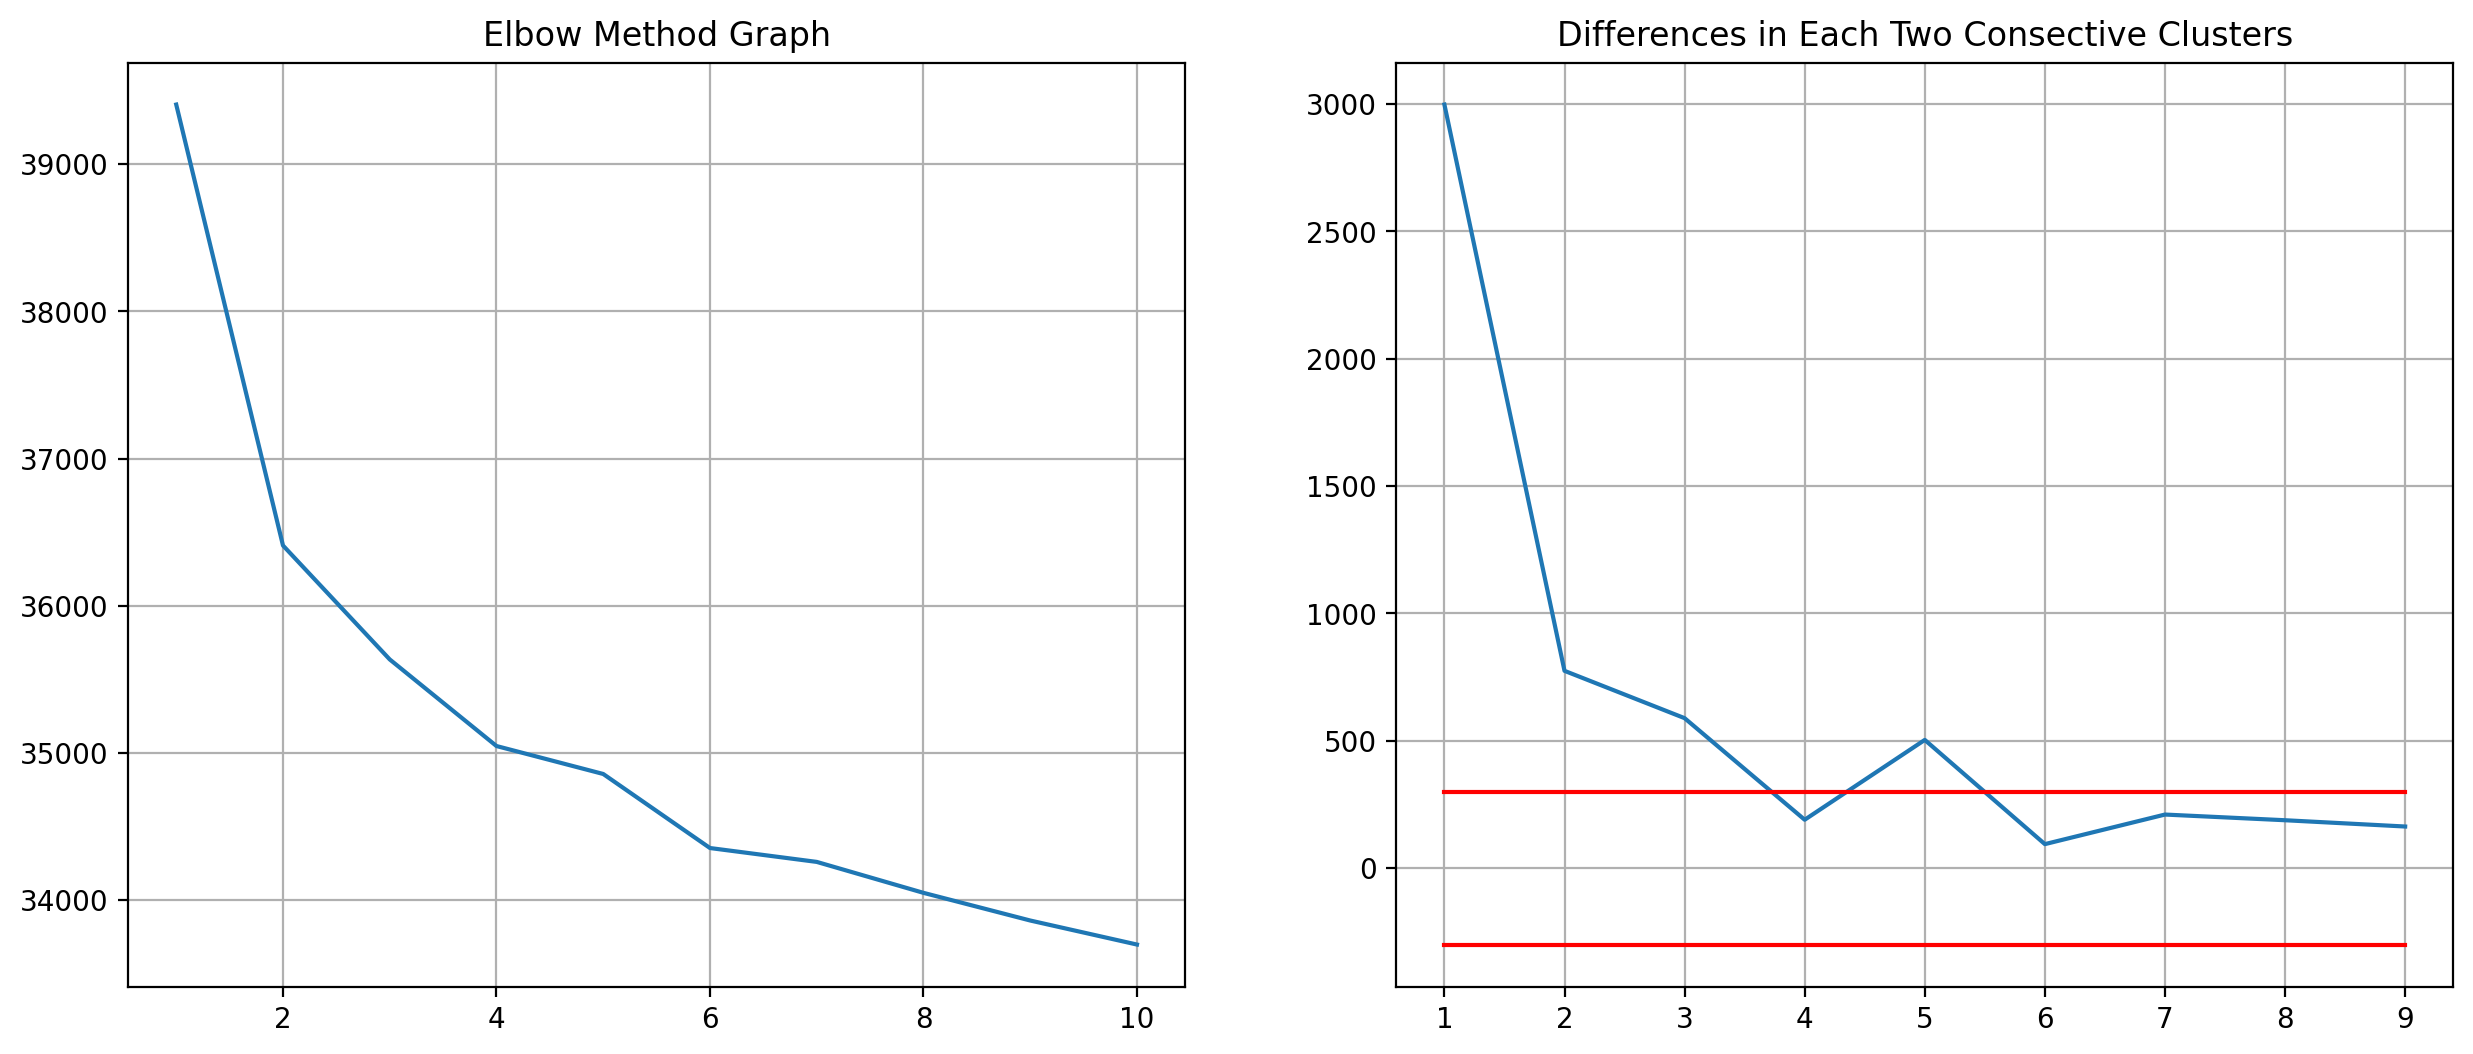

In [55]:
elbow_method.showPlot(boundary=300)

Since, we do not have any clear elbow yet and also we do not have differences inside the boundary. 
We keep studying the inertia curve for $k=11,\ 20$.

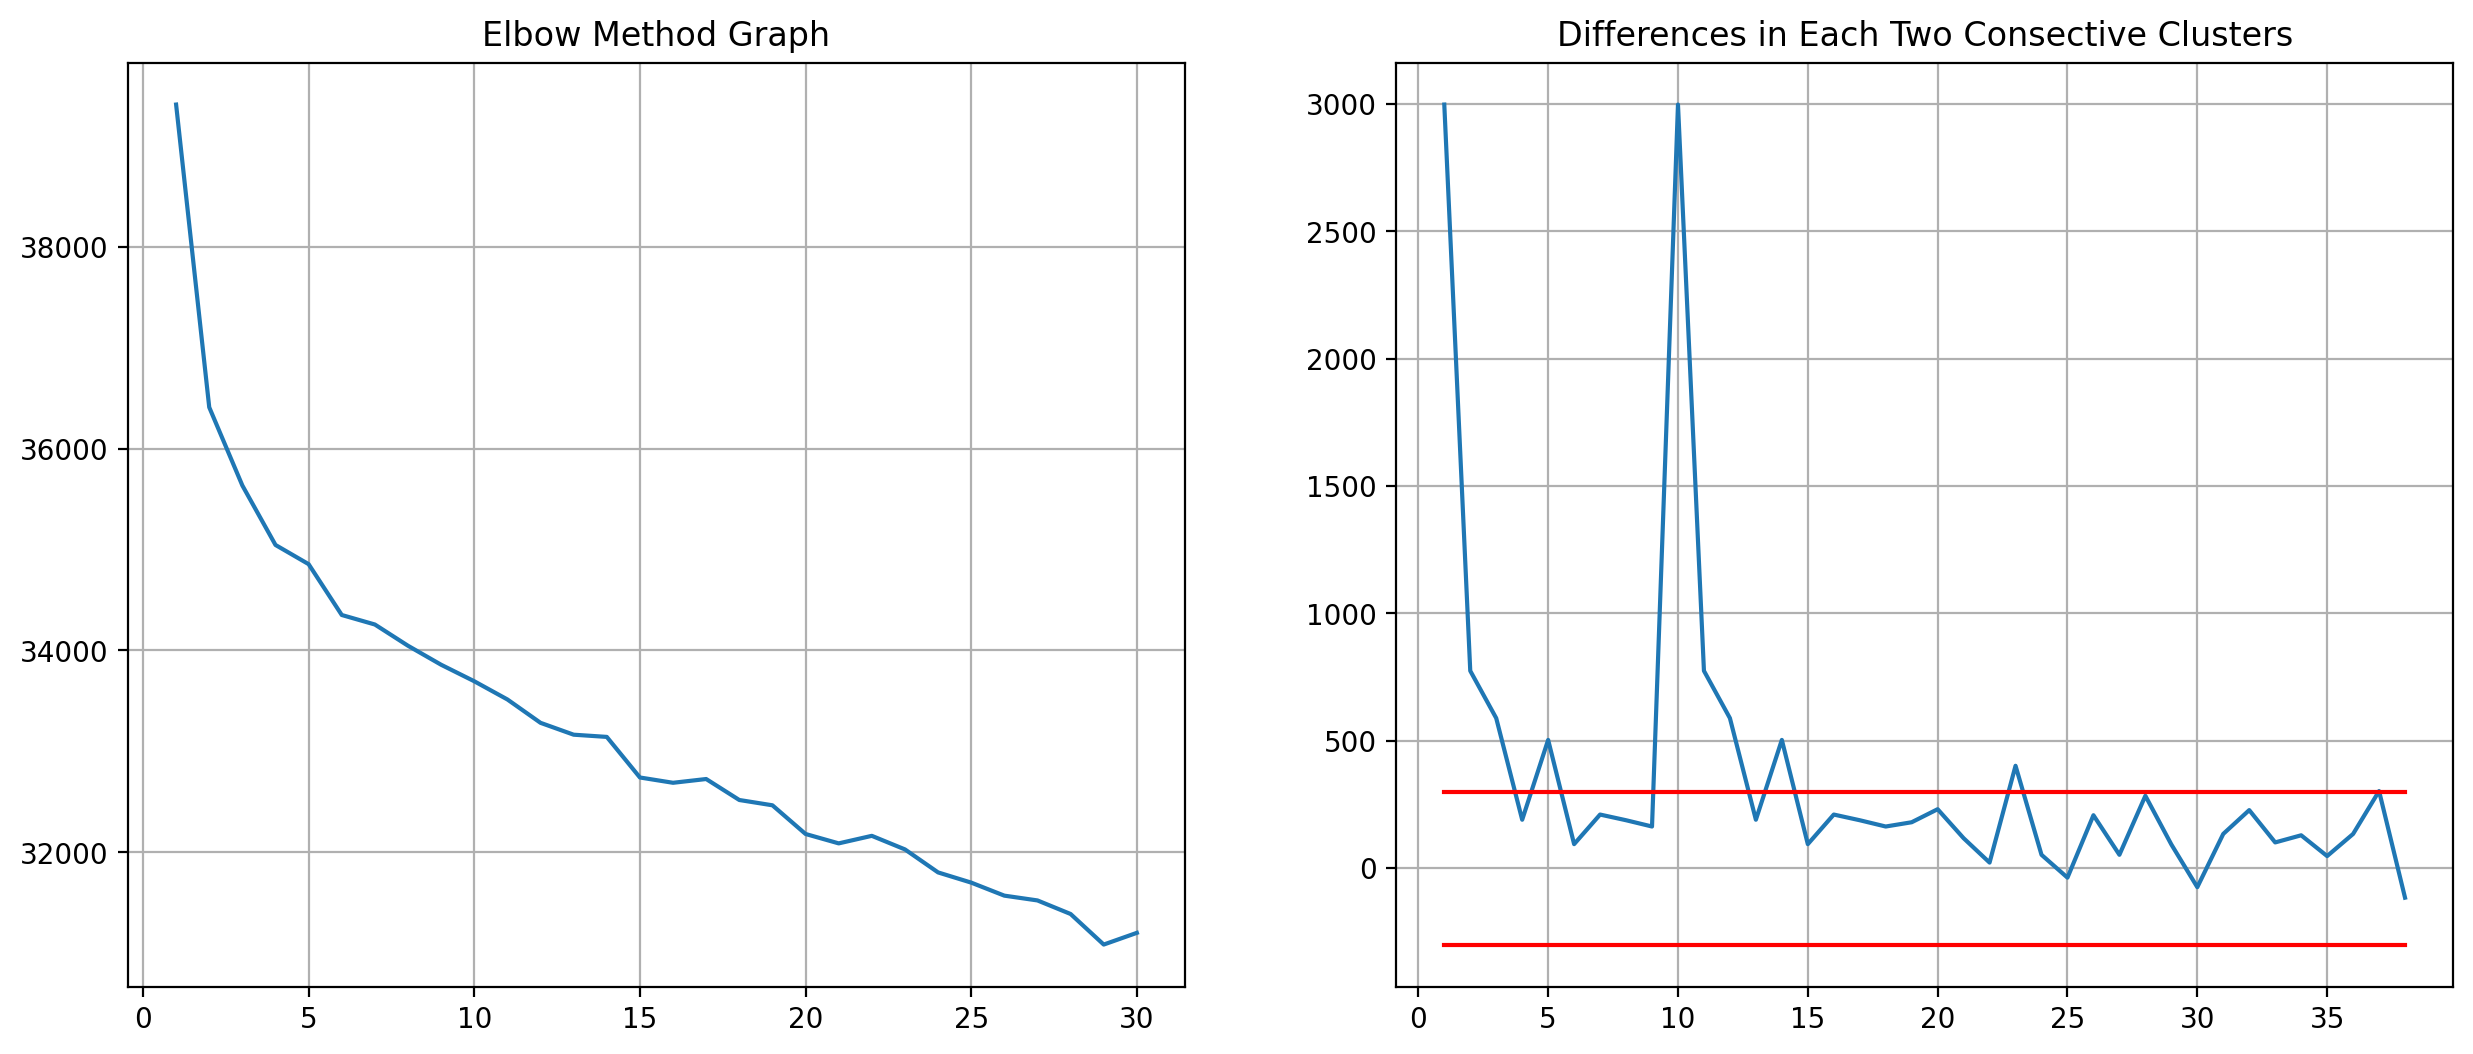

In [56]:
elbow_method.run(11, 30)
elbow_method.showPlot(boundary=300)

##### What happened?

We do not have elbow, but we have boundary in differences graph. If we look at the differences graph, we observe that after the cluster $10$, the differences are almost inside the boundary. So, we will run $k$-means for $11$ clusters because the $10^\mathrm{th}$ difference is the difference between $k=10$ and $k=11$. 

Since we have done to analyse the optimal clusters number $k$, we are now ready to fit the model and make recommendations.

### Fit model

Now let's first create the same $k$-means model and run it to make predictions.



In [57]:
kmeans = KMeans(
    n_clusters=11, init="k-means++", max_iter=300, n_init=10, random_state=42
)
clusters = kmeans.fit_predict(users_movies_matrix.astype(np.int32))

In order to better visualise the results, let's create a dataframe where we can associate a cluster number to each user.

In [58]:
users_cluster = pd.DataFrame(
    np.concatenate((users.reshape(-1, 1), clusters.reshape(-1, 1)), axis=1),
    columns=["UserId", "Cluster"],
)
users_cluster

,UserId,Cluster
0,1,0
1,2,1
2,3,10
3,4,4
4,5,10
...,...,...
938,939,1
939,940,9
940,941,1
941,942,9


Let's see how many users we have in each cluster.

In [59]:
users_cluster.groupby("Cluster").count()

,UserId
Cluster,
0,93
1,118
2,11
3,2
4,154
5,1
6,11
7,31
8,1


As, we can see that there are some clusters which contain only $1$ user or $2$ or $5$. 

As we do not want such small cluster where we cannot recommend enough movies to users. 
As the user in a cluster of size one will not get any recommendation for movies OR even user in size of cluster $2$ will not get enough recommendations. So, we have to fix such small clusters.

#### Fixing Small Clusters

We have seen that there are many clusters which includes a low number of users. 
We want to avoid this, hence we fix a minimum nuber of users per cluster: for instance, at least $10$ users in each cluster. 
Hence, we have to move users from small clusters into a larger cluster which contain more relevant movies.

##### Method 1: Use a different $k$

The most immediate way to fix such an issue is to use a lower $k$ in $k$-means clustering.

In [60]:
kmeans = KMeans(
    n_clusters=7, init="k-means++", max_iter=300, n_init=10, random_state=42
)
clusters = kmeans.fit_predict(users_movies_matrix.astype(np.int32))

In [61]:
users_cluster = pd.DataFrame(
    np.concatenate((users.reshape(-1, 1), clusters.reshape(-1, 1)), axis=1),
    columns=["UserId", "Cluster"],
)
users_cluster

,UserId,Cluster
0,1,1
1,2,0
2,3,3
3,4,3
4,5,3
...,...,...
938,939,0
939,940,1
940,941,0
941,942,1


In [62]:
users_cluster.groupby("Cluster").count()

,UserId
Cluster,
0,118
1,154
2,23
3,498
4,30
5,3
6,117


As we can see, also lowering the number of clusters, we still have to deal with a very small cluster. 

##### Method 2: change initialisation points

A further improvement one can do is to change the initialisation method and point in order to give the clustering a different initial configuration in order to converge faster.

In [63]:
kmeans = KMeans(n_clusters=5, init="random", max_iter=300, n_init=10, random_state=1)
clusters = kmeans.fit_predict(users_movies_matrix.astype(np.int32))

In [64]:
users_cluster = pd.DataFrame(
    np.concatenate((users.reshape(-1, 1), clusters.reshape(-1, 1)), axis=1),
    columns=["UserId", "Cluster"],
)
users_cluster_dict = users_cluster.set_index("UserId")["Cluster"].to_dict()
users_cluster

,UserId,Cluster
0,1,3
1,2,2
2,3,4
3,4,4
4,5,4
...,...,...
938,939,2
939,940,1
940,941,2
941,942,1


And finally, the number of users in each cluster.

In [65]:
users_cluster.groupby("Cluster").count()

,UserId
Cluster,
0,55
1,156
2,138
3,121
4,473


##### Method 3: Remove clusters whose cardinality is less than a threshold

One last possibility one has at disposal is simply removing the less relevant clusters, considering them as "outliers" or noise.

##### Method 4: Change clustering algorithm

One can also change the algorithm to another one not requiring the number of clusters to be an hyperparameter, notably something like [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) or [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) would make the job. 

Here we want to keep it simple, hence we are not going to follow this path, but if you are interested a good reference to look at is [here](https://github.com/oscar-defelice/DSAcademy-lectures/blob/master/Lectures_src/07.Unsupervised_learning/02.DBScan.ipynb).

#### Movie Count

For the sake of simplicity, we also create a dictionary containing the association of users to clusters, _i.e._ we will have clusters as keys and lists of users as values.

In [66]:
clusters_users_dict = {
    i: list(users_cluster[users_cluster.Cluster == i].UserId)
    for i in range(kmeans.n_clusters)
}

Hence, we can define a function to create a list of dataframes where each dataframe will contain the `MovieId` and the counts for that movie (_i.e._ the number of users whose favourite movie lists contains the movie). 
Thus, the movie having more counts will be of more interest to other users who has not watched that movie yet.

The list would be something like this:

```python
[dataframe_for_Cluster_1, dataframe_for_Cluster_2, ..., dataframe_for_Cluster_3]
```

Each dataframe has the following format.

<p align="center">
    <table class='dataframe'>
        <thead>
                <td>Index</td>
                <td>MovieID</td>
                <td>Count</td>
        </thead>
        <tr>
                <td>0</td>
                <td>121</td>
                <td>100</td>
        </tr>
        <tr>
                <td>1</td>
                <td>8786</td>
                <td>95</td>
        </tr>
        <tr>
                <td>&#8942;</td>
                <td>&#8942;</td>
                <td>&#8942;</td>
        </tr>
        <tr>
                <td>N-1</td>
                <td>2374</td>
                <td>1</td>
        </tr>
        <tr>
                <td>N</td>
                <td>84374</td>
                <td>1</td>
        </tr>
    </table>
</p>

where $3^\mathrm{rd}$ column of **Count** is representing the total number of users in the cluster who have appreciated that particular movie. 
Hence, we will sort movies by their count in order to prioritise the most seen movie by users in cluster and the most highly rated movie within that cluster.

Now we want to create a list of all user movies in each cluster. 

In order to do this, let's define a function.

In [67]:
def clustersMovies(
    user_clusters: Dict, users_interest: pd.DataFrame
) -> Dict[int, pd.DataFrame]:
    """Function to retrieve the movie counts for each cluster of users.

    Parameters
    ----------
    user_clusters : dict
        The dictionary containing the clusters of users.
    users_interest : pd.DataFrame
        The dataframe containing each user interests.

    Returns
    -------
    dict[int, pd.DataFrame]
        A dictionary of dataframes associating each MovieId to the number of times it has been appreciated in a cluster.
    """
    return {
        k: users_interest[users_interest.UserId.isin(user_clusters[k])].value_counts(
            "MovieId"
        )
        for k in range(kmeans.n_clusters)
    }

Now, let's take a look at any of the cluster movies.

In [68]:
cluster_movies = clustersMovies(clusters_users_dict, interest_ratings)
pd.DataFrame(cluster_movies[4], columns=["Count"])

,Count


### Making Recommendations

Finally, we are ready to write down the object to make recommendations.

Thus, we are going to create an object for recommending most favourite movies in the cluster to the user which user has not watched earlier. And also when any user has added another movie in his favourite list, then we have to update clusters movies datasets also.

First, we write an auxiliary function to get the list of user favourite movies.

In [69]:
def get_user_fav_movies(df: pd.DataFrame, user_id: int, max_lenght: int = None) -> List:
    """Auxiliary method to get the user list of favourite movies.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing users favourite movies.
    user_id : int
        The id of the user one is interested in.
    max_lenght : int, optional
        The maximum number of movies to be returned, if None, no filtering is applied.
        By default None.

    Returns
    -------
    List
        The list of movie ids, appreciated by the user.
    """
    if max_lenght is None:
        return list(df[df.UserId == user_id].MovieId)

    return list(df[df.UserId == user_id].MovieId.iloc[:max_lenght])

In [82]:
class Recommender:
    """Recommender object to retrieve recommendations for a given user.

    Parameters
    ----------

    user_id: int
        The number to identify the user.

    user_preferences: pd.DataFrame
        A dataframe containing items the user appreciated.

    users_clusters : dict
        The dictionary associating each user to its cluster.

    Attributes
    ----------

    user_cluster_: int
        The index identifying the user cluster.

    movies_cluster_count_: Dict
        The count associated with each movie in the user cluster.
    """

    def __init__(
        self, user_id: int, users_preferences: pd.DataFrame, users_clusters: Dict
    ):
        """Class constructor"""

        self.users_preferences = users_preferences.copy()
        self.user_id = user_id

        try:
            self.user_cluster_ = users_clusters[user_id]
            self.movies_cluster_count_ = clustersMovies(
                clusters_users_dict, interest_ratings
                )[self.user_cluster_]
        except KeyError:
            logging.error(f"User cluster not found, {user_id} is not a valid user.")

    def update(self, new_movie_Id: int) -> Self:
        """Method to update movie content of the recommender.

        Parameters
        ----------
        new_movie_Id : int
            The new movie id to add.

        Returns
        -------
        Recommender
            This is an inplace update of the recommender itself.
        """
        self.movies_cluster_count_[new_movie_Id] = (
            self.movies_cluster_count_.get(new_movie_Id, 0) + 1
        )
        return self

    def recommend(self) -> Union[List, None]:
        """Method to provide recommendations to the user.
        It removes the already evaluated movies from the suggested list.

        Returns
        -------

        list:
            The list of recommended movies or a string with the error message.
        """
        try:
            user_movies = get_user_fav_movies(self.users_preferences, self.user_id)

            # Remove the already evaluated movies
            self.movies_cluster_count_ = self.movies_cluster_count_.drop(user_movies)

            return self.movies_cluster_count_.keys().to_list()

        except KeyError:
            err = f"User history does not exist for user {self.user_id}"
            logging.error(err)

Now let's try it to make recommendations and to update favourite list request. 
For the sake of visualisation, we will exploit data for not only IDs but for movies details like title, genre, etc.

Let's print out for example all movies user $7$ considered as his favourite ones.

In [87]:
user_id = 1
user_id_movies = get_user_fav_movies(df=interest_ratings, user_id=user_id)

# Let's print in a nice format
print(f"User {user_id} favourite movies: \n")
for movie in user_id_movies:
    title = df_items.loc[movie].Title
    genres = get_genre(movie)
    print(f"Title: {title:>45} \t Genres: {genres}")

User 1 favourite movies: 

Title:                              Toy Story (1995) 	 Genres: ['Animation', 'Children', 'Comedy']
Title:                             Four Rooms (1995) 	 Genres: ['Thriller']
Title:                         Twelve Monkeys (1995) 	 Genres: ['Drama', 'Sci-Fi']
Title:                       Dead Man Walking (1995) 	 Genres: ['Drama']
Title:                       Mighty Aphrodite (1995) 	 Genres: ['Comedy']
Title:                     Mr. Holland's Opus (1995) 	 Genres: ['Drama']
Title:            French Twist (Gazon maudit) (1995) 	 Genres: ['Comedy', 'Romance']
Title:                     White Balloon, The (1995) 	 Genres: ['Drama']
Title:                         Antonia's Line (1995) 	 Genres: ['Drama']
Title:                             Braveheart (1995) 	 Genres: ['Drama', 'War']
Title:                          Birdcage, The (1996) 	 Genres: ['Comedy']
Title:                              Apollo 13 (1995) 	 Genres: ['Drama', 'Thriller']
Title:                   

These are the basis for the top $10$ recommendations for that user.

In [88]:
recommender = Recommender(
    user_id=user_id,
    users_preferences=interest_ratings,
    users_clusters=users_cluster_dict,
)

user_recommendations = recommender.recommend()

Again, we can print them in a nicer format.

In [89]:
print(f"Recommendations for user {user_id}: \n")
for movie in user_recommendations:
    title = df_items.loc[movie].Title
    genres = get_genre(movie)
    print(f"Title: {title:>45} \t Genres: {genres}")

Recommendations for user 1: 

Title:                Raiders of the Lost Ark (1981) 	 Genres: []
Title:        One Flew Over the Cuckoo's Nest (1975) 	 Genres: ['Drama']
Title:                                  Fargo (1996) 	 Genres: ['Crime', 'Drama', 'Thriller']
Title:              Silence of the Lambs, The (1991) 	 Genres: ['Drama', 'Thriller']
Title:                                 Psycho (1960) 	 Genres: ['Horror', 'Romance', 'Thriller']
Title:                            Taxi Driver (1976) 	 Genres: ['Drama', 'Thriller']
Title:                       Schindler's List (1993) 	 Genres: ['Drama', 'War']
Title:                           Citizen Kane (1941) 	 Genres: ['Drama']
Title:                    Clockwork Orange, A (1971) 	 Genres: ['Sci-Fi']
Title:                  To Kill a Mockingbird (1962) 	 Genres: ['Drama']
Title:                            Rear Window (1954) 	 Genres: ['Mystery', 'Thriller']
Title:                             Casablanca (1942) 	 Genres: ['Drama', 'Romance',